In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
PLOT_COLOR = "tab:orange"

import plotly.graph_objects as go
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, ParameterGrid, cross_val_score, cross_val_predict, BaseCrossValidator
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import spearmanr
from tqdm.auto import tqdm

import optuna

from xgboost import XGBRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor

import warnings
warnings.filterwarnings('ignore')

def plot_ts(ts_x: pd.Series, ts_y: pd.Series, title: str = None, figsize=(13, 5)) -> None:
    """plots a given timeseries and displays an optional title"""
    plt.figure(figsize=figsize)
    plt.plot(ts_x, ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

def plot_ts_y(ts_x, ts_y, title: str = None, figsize=(7, 4)) -> None:
    plt.figure(figsize=figsize)
    plt.plot(ts_x, label=ts_x)
    plt.plot(ts_y, label=ts_y)
    plt.title(title or '', fontsize=10)
    plt.grid(alpha=0.5, linestyle='dashed')
    plt.show()

def _safe_spearman(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    corr = spearmanr(y_true, y_pred, nan_policy="omit").correlation
    return 0.0 if (corr is None or np.isnan(corr)) else float(corr)

spearman = make_scorer(_safe_spearman, greater_is_better=True)

In [18]:
# ===========================
# 2) Load data (no destructive edits here)
# ===========================
X = pd.read_csv("data/X_train.csv")
y = pd.read_csv("data/y_train.csv")
X_test = pd.read_csv("data/X_test.csv")  # for later inference / submission if needed

# Keep originals for indexing/plotting
X_raw = X.copy()
y_raw = y["TARGET"].astype(float).copy()

In [21]:
# ===========================
# 4) Time-aware CV splitter (expanding windows by DAY_ID)
#    We'll use this only on the TRAIN portion (see step 7)
# ===========================
class BlockedByDaySplit(BaseCrossValidator):
    def __init__(self, day_series, n_splits=5, gap=0):
        self.days = np.asarray(day_series)
        self.order = np.argsort(self.days)
        self.unique_days = np.unique(self.days[self.order])
        self.n_splits = n_splits
        self.gap = gap

    def get_n_splits(self, X=None, y=None, groups=None):
        return self.n_splits

    def split(self, X, y=None, groups=None):
        days = self.unique_days
        n = len(days)
        fold_size = n // (self.n_splits + 1)  # expanding windows
        for i in range(1, self.n_splits + 1):
            train_days = days[: i * fold_size - self.gap]
            val_days   = days[i * fold_size : (i + 1) * fold_size]
            train_idx = np.where(np.isin(self.days, train_days))[0]
            val_idx   = np.where(np.isin(self.days, val_days))[0]
            yield train_idx, val_idx

In [23]:
# ===========================
# 5) Preprocessing
#    - Median impute numerics
#    - One-hot encode COUNTRY
#    - Drop others in remainder
# ===========================
feature_exclude = ["ID", "DAY_ID", "COUNTRY"]
num_cols = [c for c in X_raw.columns if c not in feature_exclude]

transformers = [
    ("num", SimpleImputer(strategy="median"), num_cols),
]
if "COUNTRY" in X_raw.columns:
    transformers.append(("ctry", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), ["COUNTRY"]))

prep = ColumnTransformer(transformers, remainder="drop")

In [ ]:
# ===========================
# 6) Chronological train/validation split by DAY_ID (hold-out at the end)
# ===========================
order = np.argsort(X_raw["DAY_ID"].values)
X_sorted = X_raw.iloc[order]
y_sorted = y_raw.iloc[order]

train_frac = 0.8  # 80% train, 20% validation (adjust as desired)
split_idx = int(len(X_sorted) * train_frac)

X_train, X_val = X_sorted.iloc[:split_idx], X_sorted.iloc[split_idx:]
y_train, y_val = y_sorted.iloc[:split_idx], y_sorted.iloc[split_idx:]

In [38]:
# ===========================
# 7) Cross-validated Spearman on TRAIN portion (time-aware)
# ===========================
cv_train = BlockedByDaySplit(day_series=X_train["DAY_ID"], n_splits=5, gap=0)

lgbm = LGBMRegressor(
    objective="regression",
    n_estimators=1500,
    learning_rate=0.03,
    num_leaves=63,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=0.0,
    verbose=-1,
    n_jobs=1,  # parallelize via CV, not inside estimator
)

pipe_lgbm = Pipeline([
    ("prep", prep),
    ("model", lgbm),
])

cv_scores = cross_val_score(
    pipe_lgbm,
    X_train, y_train,
    cv=cv_train,
    scoring=spearman,
    n_jobs=-1
)
print("Train CV Spearman:", np.mean(cv_scores).round(4), "+/-", np.std(cv_scores).round(4))

Train CV Spearman: 0.1436 +/- 0.0573


In [39]:
# 8) Fit preprocessor on TRAIN and transform both TRAIN/VAL — OK
prep_fitted = prep.fit(X_train, y_train)
Xtr = prep_fitted.transform(X_train)
Xva = prep_fitted.transform(X_val)

In [40]:
# ===========================
# 8) Fit on TRAIN with early stopping using VAL as eval_set
#    (early stopping prevents overfitting)
# ===========================
lgbm_final = LGBMRegressor(
    objective="regression",
    n_estimators=1500,
    learning_rate=0.03,
    num_leaves=63,
    min_data_in_leaf=20,
    feature_fraction=0.8,
    bagging_fraction=0.8,
    bagging_freq=1,
    reg_alpha=0.0,
    reg_lambda=0.0,
    verbose=-1,
    n_jobs=1,
)

lgbm_final.fit(
    Xtr, y_train,
    eval_set=[(Xva, y_val)],
    eval_metric="rmse",
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=0),  # silence logs
    ],
)

print("Best iteration:", lgbm_final.best_iteration_)

Best iteration: 21


In [42]:
y_val_pred = lgbm_final.predict(Xva)
val_spearman = spearmanr(y_val, y_val_pred).correlation
print("Validation Spearman:", None if val_spearman is None else round(val_spearman, 4))

Validation Spearman: 0.1397


In [44]:
# ===========================
# 10) Plot validation period: Actual vs Predicted (time-ordered)
# ===========================
fig = go.Figure()
fig.add_trace(go.Scatter(
    y=y_val.values,
    mode="lines",
    name="Actual",
    line=dict(width=2, color="rgb(67,90,108)")
))
fig.add_trace(go.Scatter(
    y=y_val_pred,
    mode="lines",
    name="Predicted",
    line=dict(width=1.5, color="rgb(242,153,74)")
))
fig.update_layout(
    title="Validation period: Actual vs Predicted (chronological)",
    xaxis_title="Time (DAY_ID order within validation)",
    yaxis_title="TARGET",
    legend=dict(orientation="h", yanchor="bottom", y=-0.4, xanchor="center", x=0.5),
    height=450, width=950, plot_bgcolor="white"
)
fig.show()

---

### Hyperparameter Optimization: HPO

In [49]:
cv_train = BlockedByDaySplit(day_series=X_train["DAY_ID"], n_splits=5, gap=0)

def fold_spearman(y_true, y_pred):
    c = spearmanr(np.asarray(y_true).ravel(), np.asarray(y_pred).ravel(), nan_policy="omit").correlation
    return 0.0 if (c is None or np.isnan(c)) else float(c)

def objective(trial: optuna.Trial) -> float:
    # Search space (variance-friendly, combats underfitting)
    params = {
        "objective": "regression",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.2, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 1_000, 10_000, step=500),  # early stopping will cut this
        "num_leaves": trial.suggest_int("num_leaves", 63, 511, step=8),
        "max_depth": trial.suggest_int("max_depth", -1, 20),  # -1 means no limit
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 8, 120, step=4),
        "min_split_gain": trial.suggest_float("min_split_gain", 0.0, 0.6),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 0.95),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 0.95),
        "bagging_freq": trial.suggest_int("bagging_freq", 0, 8),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 1),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 1),
        "random_state": 42,
        "n_jobs": 1,          # avoid nested parallelism
        "verbose": -1
    }

    # Time-aware CV with per-fold preprocessing + early stopping on the fold val
    fold_scores = []
    for tr_idx, va_idx in cv_train.split(X_train, y_train):
        X_tr_f, X_va_f = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        y_tr_f, y_va_f = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # Fit/transform preprocessor on TRAIN fold only
        prep_fold = ColumnTransformer(
            [("num", SimpleImputer(strategy="median"),
              [c for c in X_train.columns if c not in ["ID", "DAY_ID", "COUNTRY"]])]
            + ([("ctry", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), ["COUNTRY"])]
               if "COUNTRY" in X_train.columns else []),
            remainder="drop"
        )
        Xtr = prep_fold.fit_transform(X_tr_f, y_tr_f)
        Xva = prep_fold.transform(X_va_f)

        # Model with early stopping on the validation fold
        model = LGBMRegressor(**params)
        model.fit(
            Xtr, y_tr_f,
            eval_set=[(Xva, y_va_f)],
            eval_metric="rmse",
            callbacks=[
                lgb.early_stopping(stopping_rounds=100, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )

        y_va_pred = model.predict(Xva)
        fold_scores.append(fold_spearman(y_va_f, y_va_pred))

        # Optional pruning
        trial.report(np.mean(fold_scores), step=len(fold_scores))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return float(np.mean(fold_scores))

In [51]:
# Create and run study
study = optuna.create_study(direction="maximize", study_name="lgbm_spearman_ts_cv")
study.optimize(objective, n_trials=150, show_progress_bar=True)  # adjust n_trials as you like

print("Best CV Spearman:", study.best_value)
print("Best params:", study.best_params)

[I 2025-09-04 11:02:06,771] A new study created in memory with name: lgbm_spearman_ts_cv
Best trial: 1. Best value: 0.143881:   1%|▏         | 2/150 [00:00<00:47,  3.10it/s]

[I 2025-09-04 11:02:07,315] Trial 0 finished with value: 0.12873058560977443 and parameters: {'learning_rate': 0.0014823336685067898, 'n_estimators': 9500, 'num_leaves': 303, 'max_depth': 11, 'min_data_in_leaf': 120, 'min_split_gain': 0.3772976342404752, 'feature_fraction': 0.8700173628333041, 'bagging_fraction': 0.8910238645868502, 'bagging_freq': 8, 'lambda_l1': 0.3794051007741198, 'lambda_l2': 0.6678421847895829}. Best is trial 0 with value: 0.12873058560977443.
[I 2025-09-04 11:02:07,483] Trial 1 finished with value: 0.14388067771049387 and parameters: {'learning_rate': 0.033919703382745706, 'n_estimators': 6000, 'num_leaves': 95, 'max_depth': 3, 'min_data_in_leaf': 108, 'min_split_gain': 0.09347729695693685, 'feature_fraction': 0.899280357812055, 'bagging_fraction': 0.8631669314887155, 'bagging_freq': 7, 'lambda_l1': 0.09582025546162753, 'lambda_l2': 0.6189022953490151}. Best is trial 1 with value: 0.14388067771049387.


Best trial: 2. Best value: 0.189091:   2%|▏         | 3/150 [00:01<00:52,  2.80it/s]

[I 2025-09-04 11:02:07,882] Trial 2 finished with value: 0.18909120136810123 and parameters: {'learning_rate': 0.006075870975888972, 'n_estimators': 8000, 'num_leaves': 415, 'max_depth': 18, 'min_data_in_leaf': 56, 'min_split_gain': 0.12614269363081215, 'feature_fraction': 0.7978339876503423, 'bagging_fraction': 0.8975901940368869, 'bagging_freq': 1, 'lambda_l1': 0.2608487160721267, 'lambda_l2': 0.6501409521983464}. Best is trial 2 with value: 0.18909120136810123.


Best trial: 3. Best value: 0.193214:   3%|▎         | 4/150 [00:01<00:47,  3.11it/s]

[I 2025-09-04 11:02:08,149] Trial 3 finished with value: 0.19321439402952925 and parameters: {'learning_rate': 0.015475482348984729, 'n_estimators': 1500, 'num_leaves': 511, 'max_depth': 15, 'min_data_in_leaf': 76, 'min_split_gain': 0.1535978231420475, 'feature_fraction': 0.7588786835946512, 'bagging_fraction': 0.9041864706222602, 'bagging_freq': 2, 'lambda_l1': 0.03811174754054014, 'lambda_l2': 0.7986515533244706}. Best is trial 3 with value: 0.19321439402952925.


Best trial: 4. Best value: 0.211214:   5%|▍         | 7/150 [00:02<00:32,  4.34it/s]

[I 2025-09-04 11:02:08,608] Trial 4 finished with value: 0.21121435994783982 and parameters: {'learning_rate': 0.008595435914070864, 'n_estimators': 4500, 'num_leaves': 375, 'max_depth': 16, 'min_data_in_leaf': 16, 'min_split_gain': 0.2641305478849085, 'feature_fraction': 0.71274274031016, 'bagging_fraction': 0.6175643986886951, 'bagging_freq': 1, 'lambda_l1': 0.5302561465988117, 'lambda_l2': 0.652047607990409}. Best is trial 4 with value: 0.21121435994783982.
[I 2025-09-04 11:02:08,628] Trial 5 pruned. 
[I 2025-09-04 11:02:08,794] Trial 6 finished with value: 0.18156585925345767 and parameters: {'learning_rate': 0.07925792895059718, 'n_estimators': 7500, 'num_leaves': 279, 'max_depth': 11, 'min_data_in_leaf': 56, 'min_split_gain': 0.27465914899763305, 'feature_fraction': 0.7531110658227694, 'bagging_fraction': 0.8840993381021434, 'bagging_freq': 8, 'lambda_l1': 0.6486861711587628, 'lambda_l2': 0.8127863633326633}. Best is trial 4 with value: 0.21121435994783982.
[I 2025-09-04 11:02:08

Best trial: 4. Best value: 0.211214:   7%|▋         | 11/150 [00:02<00:16,  8.54it/s]

[I 2025-09-04 11:02:08,815] Trial 8 pruned. 
[I 2025-09-04 11:02:08,828] Trial 9 pruned. 
[I 2025-09-04 11:02:08,950] Trial 10 pruned. 
[I 2025-09-04 11:02:08,997] Trial 11 pruned. 


Best trial: 4. Best value: 0.211214:   9%|▊         | 13/150 [00:02<00:13, 10.10it/s]

[I 2025-09-04 11:02:09,064] Trial 12 pruned. 


Best trial: 13. Best value: 0.213441:   9%|▊         | 13/150 [00:02<00:13, 10.10it/s]

[I 2025-09-04 11:02:09,370] Trial 13 finished with value: 0.21344099465985433 and parameters: {'learning_rate': 0.03518755272696817, 'n_estimators': 1000, 'num_leaves': 431, 'max_depth': 14, 'min_data_in_leaf': 32, 'min_split_gain': 0.19735760974976319, 'feature_fraction': 0.728069634760737, 'bagging_fraction': 0.6826513452408545, 'bagging_freq': 3, 'lambda_l1': 0.2574978545764181, 'lambda_l2': 0.0935857967968351}. Best is trial 13 with value: 0.21344099465985433.


Best trial: 13. Best value: 0.213441:  10%|█         | 15/150 [00:02<00:20,  6.66it/s]

[I 2025-09-04 11:02:09,605] Trial 14 finished with value: 0.19835131625021815 and parameters: {'learning_rate': 0.052048410963633863, 'n_estimators': 5000, 'num_leaves': 423, 'max_depth': 20, 'min_data_in_leaf': 32, 'min_split_gain': 0.22293646866002956, 'feature_fraction': 0.6584723719901955, 'bagging_fraction': 0.6017846008742328, 'bagging_freq': 4, 'lambda_l1': 0.24913096940645896, 'lambda_l2': 0.04549663132643586}. Best is trial 13 with value: 0.21344099465985433.


Best trial: 13. Best value: 0.213441:  12%|█▏        | 18/150 [00:03<00:32,  4.01it/s]

[I 2025-09-04 11:02:10,534] Trial 15 finished with value: 0.19881878032464378 and parameters: {'learning_rate': 0.002692350492105267, 'n_estimators': 3500, 'num_leaves': 343, 'max_depth': 12, 'min_data_in_leaf': 36, 'min_split_gain': 0.06252072969711578, 'feature_fraction': 0.9497425694874612, 'bagging_fraction': 0.7167022660461265, 'bagging_freq': 6, 'lambda_l1': 0.2914423105759413, 'lambda_l2': 0.0021816266661513206}. Best is trial 13 with value: 0.21344099465985433.
[I 2025-09-04 11:02:10,568] Trial 16 pruned. 
[I 2025-09-04 11:02:10,620] Trial 17 pruned. 
[I 2025-09-04 11:02:10,653] Trial 18 pruned. 


Best trial: 13. Best value: 0.213441:  13%|█▎        | 20/150 [00:04<00:25,  5.14it/s]

[I 2025-09-04 11:02:10,895] Trial 19 finished with value: 0.19697198084785783 and parameters: {'learning_rate': 0.031100965030817898, 'n_estimators': 3500, 'num_leaves': 391, 'max_depth': 6, 'min_data_in_leaf': 24, 'min_split_gain': 0.23417021682684738, 'feature_fraction': 0.6464274938382515, 'bagging_fraction': 0.7491100801226476, 'bagging_freq': 1, 'lambda_l1': 0.34305569939296127, 'lambda_l2': 0.14277453720545225}. Best is trial 13 with value: 0.21344099465985433.
[I 2025-09-04 11:02:10,955] Trial 20 pruned. 


Best trial: 21. Best value: 0.213813:  16%|█▌        | 24/150 [00:05<00:28,  4.36it/s]

[I 2025-09-04 11:02:11,961] Trial 21 finished with value: 0.21381343633970618 and parameters: {'learning_rate': 0.0024455783030744587, 'n_estimators': 3500, 'num_leaves': 335, 'max_depth': 12, 'min_data_in_leaf': 40, 'min_split_gain': 0.039783487132124276, 'feature_fraction': 0.9285879329499827, 'bagging_fraction': 0.7137732964340641, 'bagging_freq': 6, 'lambda_l1': 0.3020135896717766, 'lambda_l2': 0.004889167795264323}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:12,024] Trial 22 pruned. 
[I 2025-09-04 11:02:12,126] Trial 23 pruned. 


Best trial: 21. Best value: 0.213813:  17%|█▋        | 26/150 [00:05<00:22,  5.47it/s]

[I 2025-09-04 11:02:12,175] Trial 24 pruned. 
[I 2025-09-04 11:02:12,259] Trial 25 pruned. 


Best trial: 21. Best value: 0.213813:  19%|█▊        | 28/150 [00:05<00:24,  4.96it/s]

[I 2025-09-04 11:02:12,710] Trial 26 finished with value: 0.2118426409332396 and parameters: {'learning_rate': 0.006177590640843182, 'n_estimators': 6500, 'num_leaves': 327, 'max_depth': 17, 'min_data_in_leaf': 48, 'min_split_gain': 0.19815780026360447, 'feature_fraction': 0.9106124972582652, 'bagging_fraction': 0.7178357592087131, 'bagging_freq': 2, 'lambda_l1': 0.6863907061241149, 'lambda_l2': 0.15236632801364414}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:12,752] Trial 27 pruned. 


Best trial: 21. Best value: 0.213813:  19%|█▉        | 29/150 [00:07<00:50,  2.39it/s]

[I 2025-09-04 11:02:14,224] Trial 28 finished with value: 0.20264440293223357 and parameters: {'learning_rate': 0.0010151462228396371, 'n_estimators': 5500, 'num_leaves': 199, 'max_depth': 17, 'min_data_in_leaf': 48, 'min_split_gain': 0.18599833980604524, 'feature_fraction': 0.9161161921083502, 'bagging_fraction': 0.6859501608395905, 'bagging_freq': 3, 'lambda_l1': 0.7221068308699404, 'lambda_l2': 0.02454947222362917}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:14,286] Trial 29 pruned. 


Best trial: 21. Best value: 0.213813:  21%|██        | 31/150 [00:07<00:39,  3.03it/s]

[I 2025-09-04 11:02:14,522] Trial 30 finished with value: 0.2003292944714567 and parameters: {'learning_rate': 0.05165912960366416, 'n_estimators': 6500, 'num_leaves': 471, 'max_depth': 12, 'min_data_in_leaf': 48, 'min_split_gain': 0.39805453741059266, 'feature_fraction': 0.8791637398965098, 'bagging_fraction': 0.7309653413630292, 'bagging_freq': 4, 'lambda_l1': 0.2042202317768982, 'lambda_l2': 0.228185819313197}. Best is trial 21 with value: 0.21381343633970618.


Best trial: 21. Best value: 0.213813:  21%|██▏       | 32/150 [00:08<00:43,  2.71it/s]

[I 2025-09-04 11:02:15,056] Trial 31 finished with value: 0.21182472291440027 and parameters: {'learning_rate': 0.007285984490619629, 'n_estimators': 4500, 'num_leaves': 367, 'max_depth': 15, 'min_data_in_leaf': 28, 'min_split_gain': 0.29553205448360564, 'feature_fraction': 0.9297261846423917, 'bagging_fraction': 0.6602886947137963, 'bagging_freq': 2, 'lambda_l1': 0.575551950468515, 'lambda_l2': 0.7342862945858195}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:15,099] Trial 32 pruned. 


Best trial: 21. Best value: 0.213813:  23%|██▎       | 34/150 [00:08<00:38,  3.00it/s]

[I 2025-09-04 11:02:15,594] Trial 33 finished with value: 0.21266850845623328 and parameters: {'learning_rate': 0.00685475047234205, 'n_estimators': 5000, 'num_leaves': 63, 'max_depth': 13, 'min_data_in_leaf': 44, 'min_split_gain': 0.20872984755941482, 'feature_fraction': 0.8953592830955924, 'bagging_fraction': 0.7014183979280125, 'bagging_freq': 3, 'lambda_l1': 0.6162678723115207, 'lambda_l2': 0.3385119081231749}. Best is trial 21 with value: 0.21381343633970618.


Best trial: 21. Best value: 0.213813:  25%|██▌       | 38/150 [00:09<00:22,  4.87it/s]

[I 2025-09-04 11:02:15,977] Trial 34 finished with value: 0.2112176616712654 and parameters: {'learning_rate': 0.01254587144249237, 'n_estimators': 7500, 'num_leaves': 71, 'max_depth': 13, 'min_data_in_leaf': 48, 'min_split_gain': 0.10508774961211417, 'feature_fraction': 0.8938190316247121, 'bagging_fraction': 0.6984322658461903, 'bagging_freq': 3, 'lambda_l1': 0.985139811840971, 'lambda_l2': 0.31490181157904695}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:16,022] Trial 35 pruned. 
[I 2025-09-04 11:02:16,056] Trial 36 pruned. 
[I 2025-09-04 11:02:16,110] Trial 37 pruned. 


Best trial: 21. Best value: 0.213813:  28%|██▊       | 42/150 [00:09<00:16,  6.48it/s]

[I 2025-09-04 11:02:16,496] Trial 38 finished with value: 0.20309341834084163 and parameters: {'learning_rate': 0.011509329380789288, 'n_estimators': 7000, 'num_leaves': 287, 'max_depth': 16, 'min_data_in_leaf': 52, 'min_split_gain': 0.03603125730839721, 'feature_fraction': 0.7786000844167844, 'bagging_fraction': 0.7015836676929942, 'bagging_freq': 3, 'lambda_l1': 0.27906252138213167, 'lambda_l2': 0.2759526155959513}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:16,539] Trial 39 pruned. 
[I 2025-09-04 11:02:16,586] Trial 40 pruned. 
[I 2025-09-04 11:02:16,636] Trial 41 pruned. 
[I 2025-09-04 11:02:16,696] Trial 42 pruned. 


Best trial: 21. Best value: 0.213813:  32%|███▏      | 48/150 [00:10<00:13,  7.80it/s]

[I 2025-09-04 11:02:17,144] Trial 43 finished with value: 0.20280317549866672 and parameters: {'learning_rate': 0.005863010630880053, 'n_estimators': 5500, 'num_leaves': 295, 'max_depth': 17, 'min_data_in_leaf': 44, 'min_split_gain': 0.2536031664732696, 'feature_fraction': 0.9285800652168683, 'bagging_fraction': 0.6470033034560323, 'bagging_freq': 2, 'lambda_l1': 0.7634119101201264, 'lambda_l2': 0.6347143297828441}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:17,189] Trial 44 pruned. 
[I 2025-09-04 11:02:17,226] Trial 45 pruned. 
[I 2025-09-04 11:02:17,265] Trial 46 pruned. 
[I 2025-09-04 11:02:17,294] Trial 47 pruned. 
[I 2025-09-04 11:02:17,331] Trial 48 pruned. 


Best trial: 21. Best value: 0.213813:  34%|███▍      | 51/150 [00:10<00:09, 10.20it/s]

[I 2025-09-04 11:02:17,394] Trial 49 pruned. 
[I 2025-09-04 11:02:17,455] Trial 50 pruned. 
[I 2025-09-04 11:02:17,492] Trial 51 pruned. 


Best trial: 21. Best value: 0.213813:  36%|███▌      | 54/150 [00:11<00:11,  8.71it/s]

[I 2025-09-04 11:02:17,837] Trial 52 finished with value: 0.2093349538717187 and parameters: {'learning_rate': 0.010349630881098873, 'n_estimators': 7500, 'num_leaves': 63, 'max_depth': 14, 'min_data_in_leaf': 48, 'min_split_gain': 0.11785685750018188, 'feature_fraction': 0.9218052769937205, 'bagging_fraction': 0.6617543235512348, 'bagging_freq': 3, 'lambda_l1': 0.9894728005118028, 'lambda_l2': 0.39089067070962796}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:17,879] Trial 53 pruned. 
[I 2025-09-04 11:02:17,921] Trial 54 pruned. 


Best trial: 21. Best value: 0.213813:  39%|███▉      | 59/150 [00:11<00:08, 11.26it/s]

[I 2025-09-04 11:02:18,146] Trial 55 finished with value: 0.19046158054730242 and parameters: {'learning_rate': 0.15080932107832826, 'n_estimators': 8000, 'num_leaves': 327, 'max_depth': 11, 'min_data_in_leaf': 40, 'min_split_gain': 0.05914151004197654, 'feature_fraction': 0.8983595744899204, 'bagging_fraction': 0.7045169920834974, 'bagging_freq': 2, 'lambda_l1': 0.8140234448345947, 'lambda_l2': 0.052143638032949136}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:18,188] Trial 56 pruned. 
[I 2025-09-04 11:02:18,233] Trial 57 pruned. 
[I 2025-09-04 11:02:18,269] Trial 58 pruned. 


Best trial: 21. Best value: 0.213813:  42%|████▏     | 63/150 [00:11<00:08, 10.87it/s]

[I 2025-09-04 11:02:18,538] Trial 59 finished with value: 0.19712442752750578 and parameters: {'learning_rate': 0.02777089233589456, 'n_estimators': 2500, 'num_leaves': 271, 'max_depth': 10, 'min_data_in_leaf': 44, 'min_split_gain': 0.20490325695417358, 'feature_fraction': 0.8552640409630323, 'bagging_fraction': 0.692924551270677, 'bagging_freq': 4, 'lambda_l1': 0.6674955172036692, 'lambda_l2': 0.9881099972740701}. Best is trial 21 with value: 0.21381343633970618.
[I 2025-09-04 11:02:18,590] Trial 60 pruned. 
[I 2025-09-04 11:02:18,643] Trial 61 pruned. 
[I 2025-09-04 11:02:18,693] Trial 62 pruned. 


Best trial: 21. Best value: 0.213813:  43%|████▎     | 65/150 [00:12<00:07, 11.64it/s]

[I 2025-09-04 11:02:18,751] Trial 63 pruned. 
[I 2025-09-04 11:02:18,831] Trial 64 pruned. 


Best trial: 65. Best value: 0.217173:  45%|████▍     | 67/150 [00:12<00:10,  7.65it/s]

[I 2025-09-04 11:02:19,264] Trial 65 finished with value: 0.21717341991156963 and parameters: {'learning_rate': 0.014698131161899925, 'n_estimators': 3500, 'num_leaves': 327, 'max_depth': 13, 'min_data_in_leaf': 28, 'min_split_gain': 0.19631821972368155, 'feature_fraction': 0.9347995268990564, 'bagging_fraction': 0.6395672298821472, 'bagging_freq': 1, 'lambda_l1': 0.23623295936004932, 'lambda_l2': 0.08536948154718867}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:19,331] Trial 66 pruned. 
[I 2025-09-04 11:02:19,410] Trial 67 pruned. 


Best trial: 65. Best value: 0.217173:  48%|████▊     | 72/150 [00:12<00:07, 10.85it/s]

[I 2025-09-04 11:02:19,477] Trial 68 pruned. 
[I 2025-09-04 11:02:19,513] Trial 69 pruned. 
[I 2025-09-04 11:02:19,558] Trial 70 pruned. 
[I 2025-09-04 11:02:19,642] Trial 71 pruned. 


Best trial: 65. Best value: 0.217173:  51%|█████     | 76/150 [00:13<00:05, 13.52it/s]

[I 2025-09-04 11:02:19,702] Trial 72 pruned. 
[I 2025-09-04 11:02:19,756] Trial 73 pruned. 
[I 2025-09-04 11:02:19,798] Trial 74 pruned. 
[I 2025-09-04 11:02:19,857] Trial 75 pruned. 
[I 2025-09-04 11:02:19,888] Trial 76 pruned. 


Best trial: 65. Best value: 0.217173:  54%|█████▍    | 81/150 [00:13<00:04, 16.64it/s]

[I 2025-09-04 11:02:19,937] Trial 77 pruned. 
[I 2025-09-04 11:02:19,981] Trial 78 pruned. 
[I 2025-09-04 11:02:20,040] Trial 79 pruned. 
[I 2025-09-04 11:02:20,090] Trial 80 pruned. 


Best trial: 65. Best value: 0.217173:  54%|█████▍    | 81/150 [00:13<00:04, 16.64it/s]

[I 2025-09-04 11:02:20,451] Trial 81 finished with value: 0.21414184114236332 and parameters: {'learning_rate': 0.010526114602720201, 'n_estimators': 7000, 'num_leaves': 87, 'max_depth': 14, 'min_data_in_leaf': 48, 'min_split_gain': 0.11001904176956237, 'feature_fraction': 0.9240382886600573, 'bagging_fraction': 0.6579913967416543, 'bagging_freq': 3, 'lambda_l1': 0.9803284436075699, 'lambda_l2': 0.3766705091214932}. Best is trial 65 with value: 0.21717341991156963.


Best trial: 65. Best value: 0.217173:  56%|█████▌    | 84/150 [00:14<00:09,  6.61it/s]

[I 2025-09-04 11:02:20,883] Trial 82 finished with value: 0.21387612715273127 and parameters: {'learning_rate': 0.006485058067812404, 'n_estimators': 7000, 'num_leaves': 63, 'max_depth': 13, 'min_data_in_leaf': 48, 'min_split_gain': 0.11120385410707108, 'feature_fraction': 0.9316851343951802, 'bagging_fraction': 0.6574693136818548, 'bagging_freq': 4, 'lambda_l1': 0.9452550883777656, 'lambda_l2': 0.35173442719119735}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:20,925] Trial 83 pruned. 
[I 2025-09-04 11:02:20,971] Trial 84 pruned. 


Best trial: 65. Best value: 0.217173:  58%|█████▊    | 87/150 [00:14<00:11,  5.60it/s]

[I 2025-09-04 11:02:21,560] Trial 85 finished with value: 0.2026047918332993 and parameters: {'learning_rate': 0.0042167924334215925, 'n_estimators': 7000, 'num_leaves': 87, 'max_depth': 14, 'min_data_in_leaf': 52, 'min_split_gain': 0.12757587615803695, 'feature_fraction': 0.8840281051591392, 'bagging_fraction': 0.6420340941510332, 'bagging_freq': 3, 'lambda_l1': 0.9738225942937744, 'lambda_l2': 0.349174053942145}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:21,598] Trial 86 pruned. 
[I 2025-09-04 11:02:21,633] Trial 87 pruned. 


Best trial: 65. Best value: 0.217173:  61%|██████▏   | 92/150 [00:15<00:07,  7.59it/s]

[I 2025-09-04 11:02:22,054] Trial 88 finished with value: 0.20565324925831469 and parameters: {'learning_rate': 0.007691948611761347, 'n_estimators': 6500, 'num_leaves': 63, 'max_depth': 12, 'min_data_in_leaf': 56, 'min_split_gain': 0.03453953859072155, 'feature_fraction': 0.8751522923477957, 'bagging_fraction': 0.6612466426963427, 'bagging_freq': 4, 'lambda_l1': 0.9362114408276833, 'lambda_l2': 0.4846603711532834}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:22,099] Trial 89 pruned. 
[I 2025-09-04 11:02:22,144] Trial 90 pruned. 
[I 2025-09-04 11:02:22,193] Trial 91 pruned. 
[I 2025-09-04 11:02:22,233] Trial 92 pruned. 


Best trial: 65. Best value: 0.217173:  65%|██████▌   | 98/150 [00:15<00:04, 11.50it/s]

[I 2025-09-04 11:02:22,282] Trial 93 pruned. 
[I 2025-09-04 11:02:22,338] Trial 94 pruned. 
[I 2025-09-04 11:02:22,388] Trial 95 pruned. 
[I 2025-09-04 11:02:22,430] Trial 96 pruned. 
[I 2025-09-04 11:02:22,480] Trial 97 pruned. 


Best trial: 65. Best value: 0.217173:  65%|██████▌   | 98/150 [00:15<00:04, 11.50it/s]

[I 2025-09-04 11:02:22,536] Trial 98 pruned. 


Best trial: 65. Best value: 0.217173:  69%|██████▊   | 103/150 [00:16<00:06,  7.62it/s]

[I 2025-09-04 11:02:23,387] Trial 99 finished with value: 0.21074765519665 and parameters: {'learning_rate': 0.016046244548512324, 'n_estimators': 7500, 'num_leaves': 335, 'max_depth': 14, 'min_data_in_leaf': 8, 'min_split_gain': 0.04824756321632634, 'feature_fraction': 0.9311825248069273, 'bagging_fraction': 0.707306581566325, 'bagging_freq': 3, 'lambda_l1': 0.35295731895269183, 'lambda_l2': 0.7079670006518948}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:23,427] Trial 100 pruned. 
[I 2025-09-04 11:02:23,481] Trial 101 pruned. 
[I 2025-09-04 11:02:23,537] Trial 102 pruned. 
[I 2025-09-04 11:02:23,580] Trial 103 pruned. 


Best trial: 65. Best value: 0.217173:  72%|███████▏  | 108/150 [00:17<00:04, 10.27it/s]

[I 2025-09-04 11:02:23,642] Trial 104 pruned. 
[I 2025-09-04 11:02:23,716] Trial 105 pruned. 
[I 2025-09-04 11:02:23,749] Trial 106 pruned. 
[I 2025-09-04 11:02:23,780] Trial 107 pruned. 
[I 2025-09-04 11:02:23,823] Trial 108 pruned. 


Best trial: 65. Best value: 0.217173:  75%|███████▌  | 113/150 [00:17<00:02, 14.89it/s]

[I 2025-09-04 11:02:23,885] Trial 109 pruned. 
[I 2025-09-04 11:02:23,927] Trial 110 pruned. 
[I 2025-09-04 11:02:23,969] Trial 111 pruned. 
[I 2025-09-04 11:02:24,016] Trial 112 pruned. 
[I 2025-09-04 11:02:24,072] Trial 113 pruned. 


Best trial: 65. Best value: 0.217173:  78%|███████▊  | 117/150 [00:17<00:02, 15.49it/s]

[I 2025-09-04 11:02:24,111] Trial 114 pruned. 
[I 2025-09-04 11:02:24,193] Trial 115 pruned. 
[I 2025-09-04 11:02:24,238] Trial 116 pruned. 
[I 2025-09-04 11:02:24,287] Trial 117 pruned. 


Best trial: 65. Best value: 0.217173:  79%|███████▉  | 119/150 [00:17<00:01, 17.11it/s]

[I 2025-09-04 11:02:24,329] Trial 118 pruned. 
[I 2025-09-04 11:02:24,482] Trial 119 pruned. 


Best trial: 65. Best value: 0.217173:  81%|████████  | 121/150 [00:17<00:02, 14.28it/s]

[I 2025-09-04 11:02:24,546] Trial 120 pruned. 
[I 2025-09-04 11:02:24,589] Trial 121 pruned. 


Best trial: 65. Best value: 0.217173:  84%|████████▍ | 126/150 [00:18<00:02, 10.70it/s]

[I 2025-09-04 11:02:25,052] Trial 122 finished with value: 0.2083789834424643 and parameters: {'learning_rate': 0.007703439801266679, 'n_estimators': 6500, 'num_leaves': 87, 'max_depth': 12, 'min_data_in_leaf': 52, 'min_split_gain': 0.03173675961967315, 'feature_fraction': 0.9278347503266297, 'bagging_fraction': 0.6609558011728619, 'bagging_freq': 4, 'lambda_l1': 0.9218406213231765, 'lambda_l2': 0.35497989909969413}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:25,096] Trial 123 pruned. 
[I 2025-09-04 11:02:25,140] Trial 124 pruned. 
[I 2025-09-04 11:02:25,208] Trial 125 pruned. 


Best trial: 65. Best value: 0.217173:  87%|████████▋ | 130/150 [00:18<00:01, 13.01it/s]

[I 2025-09-04 11:02:25,264] Trial 126 pruned. 
[I 2025-09-04 11:02:25,318] Trial 127 pruned. 
[I 2025-09-04 11:02:25,363] Trial 128 pruned. 
[I 2025-09-04 11:02:25,432] Trial 129 pruned. 


Best trial: 65. Best value: 0.217173:  87%|████████▋ | 130/150 [00:18<00:01, 13.01it/s]

[I 2025-09-04 11:02:25,480] Trial 130 pruned. 


Best trial: 65. Best value: 0.217173:  88%|████████▊ | 132/150 [00:19<00:02,  8.50it/s]

[I 2025-09-04 11:02:25,886] Trial 131 finished with value: 0.20359169283818163 and parameters: {'learning_rate': 0.00803458595438693, 'n_estimators': 6500, 'num_leaves': 63, 'max_depth': 12, 'min_data_in_leaf': 52, 'min_split_gain': 0.0842075536134963, 'feature_fraction': 0.8688634866313878, 'bagging_fraction': 0.6617600282795644, 'bagging_freq': 4, 'lambda_l1': 0.9536012006065366, 'lambda_l2': 0.3505627020970424}. Best is trial 65 with value: 0.21717341991156963.


Best trial: 65. Best value: 0.217173:  91%|█████████ | 136/150 [00:19<00:01,  7.70it/s]

[I 2025-09-04 11:02:26,162] Trial 132 finished with value: 0.20279317908491876 and parameters: {'learning_rate': 0.009050137271579065, 'n_estimators': 7000, 'num_leaves': 63, 'max_depth': 10, 'min_data_in_leaf': 56, 'min_split_gain': 0.0282421863648412, 'feature_fraction': 0.8765094791345825, 'bagging_fraction': 0.6609142141168923, 'bagging_freq': 5, 'lambda_l1': 0.9287177408270528, 'lambda_l2': 0.4756901826003344}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:26,208] Trial 133 pruned. 
[I 2025-09-04 11:02:26,251] Trial 134 pruned. 
[I 2025-09-04 11:02:26,292] Trial 135 pruned. 
[I 2025-09-04 11:02:26,362] Trial 136 pruned. 


Best trial: 65. Best value: 0.217173:  93%|█████████▎| 140/150 [00:19<00:00, 11.82it/s]

[I 2025-09-04 11:02:26,401] Trial 137 pruned. 
[I 2025-09-04 11:02:26,456] Trial 138 pruned. 
[I 2025-09-04 11:02:26,527] Trial 139 pruned. 
[I 2025-09-04 11:02:26,586] Trial 140 pruned. 


Best trial: 65. Best value: 0.217173:  95%|█████████▍| 142/150 [00:20<00:00,  8.03it/s]

[I 2025-09-04 11:02:27,017] Trial 141 finished with value: 0.2084477942804957 and parameters: {'learning_rate': 0.008559395497830965, 'n_estimators': 6500, 'num_leaves': 63, 'max_depth': 12, 'min_data_in_leaf': 52, 'min_split_gain': 0.09185257140021635, 'feature_fraction': 0.8633837231508976, 'bagging_fraction': 0.6623619247146485, 'bagging_freq': 4, 'lambda_l1': 0.9503062189483766, 'lambda_l2': 0.38570944907978405}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:27,068] Trial 142 pruned. 


Best trial: 65. Best value: 0.217173:  97%|█████████▋| 145/150 [00:20<00:00,  6.33it/s]

[I 2025-09-04 11:02:27,521] Trial 143 finished with value: 0.2050840352086596 and parameters: {'learning_rate': 0.0066701854957305915, 'n_estimators': 6500, 'num_leaves': 263, 'max_depth': 12, 'min_data_in_leaf': 48, 'min_split_gain': 0.01579082588015658, 'feature_fraction': 0.8714281735009369, 'bagging_fraction': 0.679435932007594, 'bagging_freq': 4, 'lambda_l1': 0.9443913412370898, 'lambda_l2': 0.5326162402256805}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:27,566] Trial 144 pruned. 
[I 2025-09-04 11:02:27,610] Trial 145 pruned. 


Best trial: 65. Best value: 0.217173:  98%|█████████▊| 147/150 [00:21<00:00,  6.62it/s]

[I 2025-09-04 11:02:27,937] Trial 146 finished with value: 0.2014200114318799 and parameters: {'learning_rate': 0.017017025643390072, 'n_estimators': 1500, 'num_leaves': 87, 'max_depth': 15, 'min_data_in_leaf': 52, 'min_split_gain': 0.19963970314188637, 'feature_fraction': 0.9233757281474683, 'bagging_fraction': 0.7120518096568234, 'bagging_freq': 5, 'lambda_l1': 0.24059720662684947, 'lambda_l2': 0.4277823011873991}. Best is trial 65 with value: 0.21717341991156963.


Best trial: 65. Best value: 0.217173: 100%|██████████| 150/150 [00:21<00:00,  6.86it/s]

[I 2025-09-04 11:02:28,549] Trial 147 finished with value: 0.19690755652087993 and parameters: {'learning_rate': 0.005742493059861499, 'n_estimators': 7500, 'num_leaves': 335, 'max_depth': 13, 'min_data_in_leaf': 56, 'min_split_gain': 0.05592065009750572, 'feature_fraction': 0.7537575778103274, 'bagging_fraction': 0.7021253446146105, 'bagging_freq': 4, 'lambda_l1': 0.2862999012396045, 'lambda_l2': 0.09659806091636274}. Best is trial 65 with value: 0.21717341991156963.
[I 2025-09-04 11:02:28,599] Trial 148 pruned. 
[I 2025-09-04 11:02:28,646] Trial 149 pruned. 
Best CV Spearman: 0.21717341991156963
Best params: {'learning_rate': 0.014698131161899925, 'n_estimators': 3500, 'num_leaves': 327, 'max_depth': 13, 'min_data_in_leaf': 28, 'min_split_gain': 0.19631821972368155, 'feature_fraction': 0.9347995268990564, 'bagging_fraction': 0.6395672298821472, 'bagging_freq': 1, 'lambda_l1': 0.23623295936004932, 'lambda_l2': 0.08536948154718867}


In [52]:
# ===========================
# Refit final model on TRAIN with early stopping on hold-out VAL
# ===========================
best_params = dict(study.best_params)
best_params.update({
    "objective": "regression",
    "boosting_type": "gbdt",
    "random_state": 42,
    "n_jobs": 1,
    "verbose": -1
})

# Fit preprocessor on full TRAIN, transform TRAIN/VAL
prep_fitted = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"),
      [c for c in X_train.columns if c not in ["ID", "DAY_ID", "COUNTRY"]])]
    + ([("ctry", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), ["COUNTRY"])]
       if "COUNTRY" in X_train.columns else []),
    remainder="drop"
).fit(X_train, y_train)

Xtr = prep_fitted.transform(X_train)
Xva = prep_fitted.transform(X_val)

final_model = LGBMRegressor(**best_params)
final_model.fit(
    Xtr, y_train,
    eval_set=[(Xva, y_val)],
    eval_metric="rmse",
    callbacks=[
        lgb.early_stopping(stopping_rounds=100, verbose=False),
        lgb.log_evaluation(period=0)
    ]
)
print("Best iteration (final):", final_model.best_iteration_)


Best iteration (final): 70


In [55]:
# Validation performance
y_val_pred = final_model.predict(Xva)
val_spearman = spearmanr(y_val, y_val_pred).correlation
print("Validation Spearman (hold-out):", None if val_spearman is None else round(val_spearman, 4))

# ===========================
# Optional: plot validation curve
# ===========================
fig = go.Figure()
fig.add_trace(go.Scatter(y=y_val.values, mode="lines", name="Actual",    line=dict(width=2,   color="rgb(67,90,108)")))
fig.add_trace(go.Scatter(y=y_val_pred,   mode="lines", name="Predicted", line=dict(width=1.5, color="rgb(242,153,74)")))
fig.update_layout(
    title="Validation period: Actual vs Predicted",
    xaxis_title="Time (DAY_ID order within validation)",
    yaxis_title="TARGET",
    legend=dict(orientation="h", yanchor="bottom", y=-0.3, xanchor="center", x=0.5),
    height=450, width=950, plot_bgcolor="white"
)
fig.show()

Validation Spearman (hold-out): 0.1564


It's still underfitting!

---


### Make the models country-specifc

In [78]:
def split_country(X, y, country):
    mask = (X["COUNTRY"] == country)
    return X[mask], y[mask]

def spearman_metric(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    c = spearmanr(y_true, y_pred, nan_policy="omit").correlation
    return 0.0 if (c is None or np.isnan(c)) else float(c)

In [ ]:
# ===========================
# Imports
# ===========================
import numpy as np
import pandas as pd
from scipy.stats import spearmanr

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from lightgbm import LGBMRegressor
import lightgbm as lgb
from xgboost import XGBRegressor

# ---------------------------
# Utilities
# ---------------------------
def spearman_metric(y_true, y_pred):
    y_true = np.asarray(y_true).ravel()
    y_pred = np.asarray(y_pred).ravel()
    c = spearmanr(y_true, y_pred, nan_policy="omit").correlation
    return 0.0 if (c is None or np.isnan(c)) else float(c)

def country_split(X, y, country):
    m = (X["COUNTRY"] == country)
    return X[m].copy(), y[m].copy()

# ===========================
# Feature engineering
# ===========================
def add_engineered_features(df: pd.DataFrame) -> pd.DataFrame:
    """Add interaction/spread features for both FR and DE. Works in-place on a copy."""
    df = df.copy()

    def have(*cols):
        return all(c in df.columns for c in cols)

    eps = 1e-6

    # --- Net balance (imports minus exports)
    if have("FR_NET_IMPORT", "FR_NET_EXPORT"):
        df["FR_NET_BALANCE"] = df["FR_NET_IMPORT"] - df["FR_NET_EXPORT"]
    if have("DE_NET_IMPORT", "DE_NET_EXPORT"):
        df["DE_NET_BALANCE"] = df["DE_NET_IMPORT"] - df["DE_NET_EXPORT"]

    # --- Exchange sums & skew
    if have("DE_FR_EXCHANGE", "FR_DE_EXCHANGE"):
        df["EXCHANGE_TOTAL"] = df["DE_FR_EXCHANGE"] + df["FR_DE_EXCHANGE"]
        df["EXCHANGE_SKEW"]  = df["FR_DE_EXCHANGE"] - df["DE_FR_EXCHANGE"]

    # --- Cross-border flow differentials
    if have("FR_NET_IMPORT", "DE_NET_EXPORT"):
        df["FR_DE_FLOW_DIFF"] = df["FR_NET_IMPORT"] - df["DE_NET_EXPORT"]

    # --- Renewables bundle per country
    for ctry in ["FR", "DE"]:
        parts = [f"{ctry}_WINDPOW", f"{ctry}_SOLAR", f"{ctry}_HYDRO"]
        if have(*parts):
            df[f"{ctry}_RENEWABLES"] = df[parts].sum(axis=1)

    # --- Residual / Consumption ratio
    for ctry in ["FR", "DE"]:
        r, c = f"{ctry}_RESIDUAL_LOAD", f"{ctry}_CONSUMPTION"
        if have(r, c):
            df[f"{ctry}_RESIDUAL_RATIO"] = df[r] / (df[c] + eps)

    # --- Weather × demand interactions (FR focus)
    if have("FR_WINDPOW", "FR_CONSUMPTION"):
        df["FR_WIND_DEMAND"] = df["FR_WINDPOW"] * df["FR_CONSUMPTION"]
    if have("FR_TEMP", "FR_CONSUMPTION"):
        df["FR_TEMP_DEMAND"] = df["FR_TEMP"] * df["FR_CONSUMPTION"]

    # --- Cross-country weather/production spreads
    pairs = [
        ("TEMP",), ("WIND",), ("RAIN",),
        ("WINDPOW",), ("SOLAR",), ("HYDRO",),
        ("RESIDUAL_LOAD",), ("CONSUMPTION",)
    ]
    for (base,) in pairs:
        fr, de = f"FR_{base}", f"DE_{base}"
        if have(fr, de):
            df[f"{base}_DIFF_FR_DE"] = df[fr] - df[de]

    # --- Commodity × system interactions
    # (Adjust freely; these often help rank in FR)
    if have("CARBON_RET", "FR_RESIDUAL_LOAD"):
        df["CARBON_x_FR_RESID"] = df["CARBON_RET"] * df["FR_RESIDUAL_LOAD"]
    if have("GAS_RET", "FR_CONSUMPTION"):
        df["GASRET_x_FR_CONS"] = df["GAS_RET"] * df["FR_CONSUMPTION"]
    if have("COAL_RET", "FR_LIGNITE"):
        df["COALRET_x_FR_LIGNITE"] = df["COAL_RET"] * df.get("FR_LIGNITE", 0)

    # Mirror for DE (optional; can comment out if you only want FR boosted)
    if have("CARBON_RET", "DE_RESIDUAL_LOAD"):
        df["CARBON_x_DE_RESID"] = df["CARBON_RET"] * df["DE_RESIDUAL_LOAD"]
    if have("GAS_RET", "DE_CONSUMPTION"):
        df["GASRET_x_DE_CONS"] = df["GAS_RET"] * df["DE_CONSUMPTION"]
    if have("COAL_RET", "DE_LIGNITE"):
        df["COALRET_x_DE_LIGNITE"] = df["COAL_RET"] * df.get("DE_LIGNITE", 0)

    return df

# ===========================
# Model trainers (per country)
# ===========================
def lgbm_country_fit(Xtr_c, ytr_c, Xva_c, yva_c,
                     params=None, early_stopping_rounds=200):
    # numeric columns only
    num_cols = [c for c in Xtr_c.columns if c not in ["ID", "DAY_ID", "COUNTRY"]]
    prep = ColumnTransformer(
        [("num", SimpleImputer(strategy="median"), num_cols)],
        remainder="drop"
    ).fit(Xtr_c, ytr_c)

    Xt = prep.transform(Xtr_c)
    Xv = prep.transform(Xva_c)

    P = dict(
        objective="regression",
        n_estimators=6_000, # 6_000          # big; early stopping will trim
        learning_rate=0.03,
        num_leaves=191,             # ↑ capacity to capture variance
        max_depth=-1,
        min_data_in_leaf=12,
        feature_fraction=0.9,
        bagging_fraction=0.9,
        bagging_freq=1,
        reg_alpha=0.0,
        reg_lambda=0.0,
        n_jobs=1,
        verbose=-1
    )
    if params: P.update(params)

    model = LGBMRegressor(**P)
    model.fit(
        Xt, ytr_c,
        eval_set=[(Xv, yva_c)],
        eval_metric="rmse",
        callbacks=[
            lgb.early_stopping(stopping_rounds=early_stopping_rounds, verbose=False),
            lgb.log_evaluation(period=0)
        ]
    )
    yv_pred = model.predict(Xv)
    sc = spearman_metric(yva_c, yv_pred)
    return prep, model, sc, yv_pred

# ===========================
# Apply feature engineering, split, and train
# (Assumes you already have X_train, y_train, X_val, y_val from your chronological split)
# ===========================
# Build engineered features on concatenated DF to keep column alignment
X_all = pd.concat([X_train, X_val], axis=0)
X_all_en = add_engineered_features(X_all)

# Split back to train / val
X_train_en = X_all_en.iloc[:len(X_train)].copy()
X_val_en   = X_all_en.iloc[len(X_train):].copy()

# Per-country splits
Xtr_DE, ytr_DE = country_split(X_train_en, y_train, "DE")
Xva_DE, yva_DE = country_split(X_val_en,   y_val,   "DE")
Xtr_FR, ytr_FR = country_split(X_train_en, y_train, "FR")
Xva_FR, yva_FR = country_split(X_val_en,   y_val,   "FR")

# --- Train LGBM per country
prep_lgb_DE, lgb_DE, sc_lgb_DE, pred_lgb_DE = lgbm_country_fit(Xtr_DE, ytr_DE, Xva_DE, yva_DE)
prep_lgb_FR, lgb_FR, sc_lgb_FR, pred_lgb_FR = lgbm_country_fit(Xtr_FR, ytr_FR, Xva_FR, yva_FR)
print(f"LGBM Validation Spearman — DE: {sc_lgb_DE:.4f}, FR: {sc_lgb_FR:.4f}, avg: {np.nanmean([sc_lgb_DE, sc_lgb_FR]):.4f}")

LGBM Validation Spearman — DE: 0.4227, FR: 0.0756, avg: 0.2491


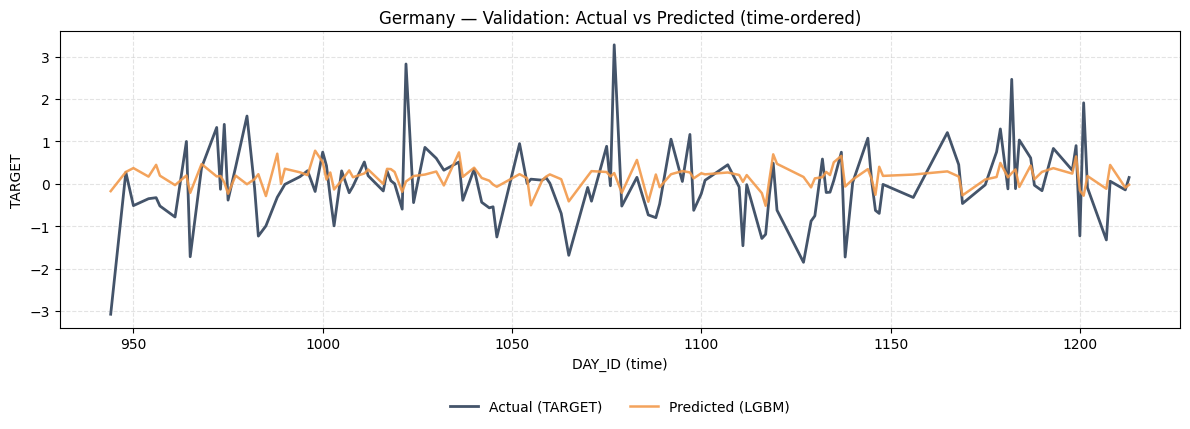

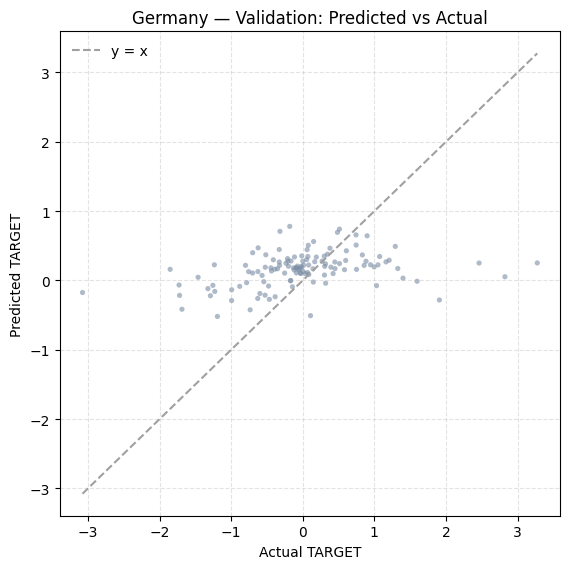

[DE] Validation Spearman: 0.4227
[DE] Validation RMSE:     0.8498


In [125]:
# ===========================
# Plots for Germany (validation): Actual vs Predicted
# Requires: Xva_DE, yva_DE, pred_lgb_DE from your previous cell
# ===========================
# Align to common index (just in case)
y_true_de = yva_DE.copy()
y_pred_de = pd.Series(pred_lgb_DE, index=yva_DE.index, name="pred")

# Order by time if DAY_ID exists
if "DAY_ID" in Xva_DE.columns:
    order = Xva_DE["DAY_ID"].sort_values().index
    y_true_plot = y_true_de.loc[order]
    y_pred_plot = y_pred_de.loc[order]
    x_axis = Xva_DE.loc[order, "DAY_ID"].values
    x_label = "DAY_ID (time)"
else:
    y_true_plot = y_true_de
    y_pred_plot = y_pred_de
    x_axis = np.arange(len(y_true_plot))
    x_label = "Observation index"

# Metrics
spearman = spearmanr(y_true_plot.values, y_pred_plot.values, nan_policy="omit").correlation
rmse = mean_squared_error(y_true_plot.values, y_pred_plot.values, squared=False)

# ---- (A) Time-series line plot ----
plt.figure(figsize=(12, 4.5))
plt.plot(x_axis, y_true_plot.values, label="Actual (TARGET)", linewidth=2, color="#44546A")
plt.plot(x_axis, y_pred_plot.values, label="Predicted (LGBM)", linewidth=1.8, alpha=0.9, color="#F2994A")
plt.title("Germany — Validation: Actual vs Predicted (time-ordered)")
plt.xlabel(x_label)
plt.ylabel("TARGET")
plt.grid(alpha=0.35, linestyle="--")
# Place legend outside
plt.legend(loc="upper center", bbox_to_anchor=(0.5, -0.2), ncol=2, frameon=False)
plt.tight_layout()
plt.show()

# ---- (B) Scatter with 45° line ----
plt.figure(figsize=(5.8, 5.8))
plt.scatter(y_true_de, y_pred_de, s=14, alpha=0.6, edgecolor="none", color="#7A8CA5")
mn = float(np.nanmin([y_true_de.min(), y_pred_de.min()]))
mx = float(np.nanmax([y_true_de.max(), y_pred_de.max()]))
plt.plot([mn, mx], [mn, mx], linestyle="--", linewidth=1.5, color="#A0A0A0", label="y = x")
plt.title("Germany — Validation: Predicted vs Actual")
plt.xlabel("Actual TARGET")
plt.ylabel("Predicted TARGET")
plt.grid(alpha=0.35, linestyle="--")
plt.legend(frameon=False)
plt.tight_layout()
plt.show()

print(f"[DE] Validation Spearman: {spearman:.4f}")
print(f"[DE] Validation RMSE:     {rmse:.4f}")

In [ ]:
def objective(trial):
    # Core tree shape / regularization (still searched independently)
    params = {
            "objective": "regression",
            "n_estimators": 6000,
            "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.25, log=True),
            "num_leaves": trial.suggest_int("num_leaves", 31, 1023, log=True),
            "max_depth": trial.suggest_int("max_depth", -1, 12),
            "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 5, 50),
            "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
            "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
            "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
            "reg_alpha": trial.suggest_float("reg_alpha", 0.0, 10.0),
            "reg_lambda": trial.suggest_float("reg_lambda", 0.0, 10.0),
            "n_jobs": 1,
            "verbose": -1,
        }

    # Preprocess (median impute numerics only)
    num_cols = [c for c in Xtr_DE.columns if c not in ["ID","DAY_ID","COUNTRY"]]
    prep = ColumnTransformer([("num", SimpleImputer(strategy="median"), num_cols)],
                             remainder="drop").fit(Xtr_DE, ytr_DE)
    Xt = prep.transform(Xtr_DE)
    Xv = prep.transform(Xva_DE)

    model = LGBMRegressor(**params)
    model.fit(
        Xt, ytr_DE,
        eval_set=[(Xv, yva_DE)],
        eval_metric="rmse",
        callbacks=[lgb.early_stopping(stopping_rounds=300, verbose=False),
                   lgb.log_evaluation(period=0)]
    )
    preds = model.predict(Xv)
    return spearman_metric(yva_DE, preds)

# Run Optuna study
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=200, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best Spearman:", study.best_value)

# Best params: {'learning_rate': 0.08306320613415273, 'num_leaves': 674, 'max_depth': 7, 'min_data_in_leaf': 49, 'feature_fraction': 0.9495022433234174, 'bagging_fraction': 0.6007416126537491, 'bagging_freq': 7, 'reg_alpha': 7.89963591204457, 'reg_lambda': 4.203535328336757}
# Best Spearman: 0.5414576661774515

[I 2025-09-04 13:05:41,177] A new study created in memory with name: no-name-cb6b4c17-76e5-47f7-9b6d-609d338176b4
Best trial: 0. Best value: 0.412022:   1%|          | 2/200 [00:00<00:31,  6.32it/s]

[I 2025-09-04 13:05:41,354] Trial 0 finished with value: 0.41202228785904993 and parameters: {'learning_rate': 0.013942468918370296, 'num_leaves': 145, 'max_depth': 9, 'min_data_in_leaf': 30, 'feature_fraction': 0.6059239509979083, 'bagging_fraction': 0.614094677432932, 'bagging_freq': 5, 'reg_alpha': 8.51744028830179, 'reg_lambda': 9.442352539343112}. Best is trial 0 with value: 0.41202228785904993.
[I 2025-09-04 13:05:41,502] Trial 1 finished with value: 0.3853168410055333 and parameters: {'learning_rate': 0.007380055270442389, 'num_leaves': 238, 'max_depth': 10, 'min_data_in_leaf': 49, 'feature_fraction': 0.6472325801353523, 'bagging_fraction': 0.973737108410894, 'bagging_freq': 4, 'reg_alpha': 5.6886817200229505, 'reg_lambda': 3.849315472380692}. Best is trial 0 with value: 0.41202228785904993.


Best trial: 0. Best value: 0.412022:   2%|▏         | 4/200 [00:00<00:34,  5.65it/s]

[I 2025-09-04 13:05:41,685] Trial 2 finished with value: 0.3946743883091925 and parameters: {'learning_rate': 0.046494966116751045, 'num_leaves': 70, 'max_depth': -1, 'min_data_in_leaf': 26, 'feature_fraction': 0.9214677308196527, 'bagging_fraction': 0.880947388700764, 'bagging_freq': 3, 'reg_alpha': 1.7976847503997428, 'reg_lambda': 4.303901192694383}. Best is trial 0 with value: 0.41202228785904993.
[I 2025-09-04 13:05:41,874] Trial 3 finished with value: 0.36679521739691223 and parameters: {'learning_rate': 0.0054709584429049225, 'num_leaves': 40, 'max_depth': 0, 'min_data_in_leaf': 28, 'feature_fraction': 0.8649449036767553, 'bagging_fraction': 0.6749576285946614, 'bagging_freq': 1, 'reg_alpha': 7.888476895165026, 'reg_lambda': 4.647829886835612}. Best is trial 0 with value: 0.41202228785904993.


Best trial: 0. Best value: 0.412022:   3%|▎         | 6/200 [00:00<00:27,  6.96it/s]

[I 2025-09-04 13:05:42,007] Trial 4 finished with value: 0.3549934864763772 and parameters: {'learning_rate': 0.011030980434613693, 'num_leaves': 272, 'max_depth': -1, 'min_data_in_leaf': 29, 'feature_fraction': 0.6732733949092802, 'bagging_fraction': 0.7808700228093419, 'bagging_freq': 1, 'reg_alpha': 7.0312052913111405, 'reg_lambda': 4.701736809879806}. Best is trial 0 with value: 0.41202228785904993.
[I 2025-09-04 13:05:42,117] Trial 5 finished with value: 0.32286243603516523 and parameters: {'learning_rate': 0.1669422581851853, 'num_leaves': 960, 'max_depth': -1, 'min_data_in_leaf': 36, 'feature_fraction': 0.7649038791438897, 'bagging_fraction': 0.7589597353922015, 'bagging_freq': 5, 'reg_alpha': 6.062249818241306, 'reg_lambda': 7.324724381781516}. Best is trial 0 with value: 0.41202228785904993.


Best trial: 6. Best value: 0.425765:   4%|▎         | 7/200 [00:01<00:32,  5.95it/s]

[I 2025-09-04 13:05:42,335] Trial 6 finished with value: 0.4257651777998479 and parameters: {'learning_rate': 0.0016796610374692205, 'num_leaves': 284, 'max_depth': 1, 'min_data_in_leaf': 36, 'feature_fraction': 0.9163400902469115, 'bagging_fraction': 0.6270743077548327, 'bagging_freq': 2, 'reg_alpha': 7.775170072429852, 'reg_lambda': 2.6437357577674616}. Best is trial 6 with value: 0.4257651777998479.
[I 2025-09-04 13:05:42,414] Trial 7 finished with value: 0.37859049928415733 and parameters: {'learning_rate': 0.03661227394445028, 'num_leaves': 139, 'max_depth': 7, 'min_data_in_leaf': 49, 'feature_fraction': 0.8089651330695242, 'bagging_fraction': 0.707705334008165, 'bagging_freq': 3, 'reg_alpha': 7.365935943706358, 'reg_lambda': 9.979784755033233}. Best is trial 6 with value: 0.4257651777998479.


Best trial: 6. Best value: 0.425765:   4%|▍         | 9/200 [00:01<00:34,  5.61it/s]

[I 2025-09-04 13:05:42,713] Trial 8 finished with value: 0.3710967226012821 and parameters: {'learning_rate': 0.0038767310257415565, 'num_leaves': 963, 'max_depth': 0, 'min_data_in_leaf': 36, 'feature_fraction': 0.7097202335002377, 'bagging_fraction': 0.9040028937863951, 'bagging_freq': 7, 'reg_alpha': 2.8767542442325835, 'reg_lambda': 3.9128141755412624}. Best is trial 6 with value: 0.4257651777998479.


Best trial: 6. Best value: 0.425765:   5%|▌         | 10/200 [00:01<00:43,  4.35it/s]

[I 2025-09-04 13:05:43,092] Trial 9 finished with value: 0.3756239439707988 and parameters: {'learning_rate': 0.0017477693806194883, 'num_leaves': 256, 'max_depth': 8, 'min_data_in_leaf': 48, 'feature_fraction': 0.8970674233059084, 'bagging_fraction': 0.9153669616990252, 'bagging_freq': 2, 'reg_alpha': 6.085615082294389, 'reg_lambda': 8.758227634718631}. Best is trial 6 with value: 0.4257651777998479.


Best trial: 6. Best value: 0.425765:   6%|▌         | 12/200 [00:02<00:47,  3.98it/s]

[I 2025-09-04 13:05:43,614] Trial 10 finished with value: 0.38846396925100934 and parameters: {'learning_rate': 0.001258372661766928, 'num_leaves': 445, 'max_depth': 3, 'min_data_in_leaf': 6, 'feature_fraction': 0.9975655878175448, 'bagging_fraction': 0.6094732713782103, 'bagging_freq': 7, 'reg_alpha': 9.951466438674183, 'reg_lambda': 0.9432670125420031}. Best is trial 6 with value: 0.4257651777998479.
[I 2025-09-04 13:05:43,717] Trial 11 finished with value: 0.32688859939895015 and parameters: {'learning_rate': 0.022948609222706556, 'num_leaves': 106, 'max_depth': 12, 'min_data_in_leaf': 18, 'feature_fraction': 0.6188734655558099, 'bagging_fraction': 0.6026171334216692, 'bagging_freq': 5, 'reg_alpha': 9.644483171097807, 'reg_lambda': 1.3809304057031122}. Best is trial 6 with value: 0.4257651777998479.


Best trial: 12. Best value: 0.430598:   7%|▋         | 14/200 [00:02<00:33,  5.59it/s]

[I 2025-09-04 13:05:43,825] Trial 12 finished with value: 0.4305975864426542 and parameters: {'learning_rate': 0.11823115940536441, 'num_leaves': 449, 'max_depth': 4, 'min_data_in_leaf': 38, 'feature_fraction': 0.7668208422445223, 'bagging_fraction': 0.6710365581628142, 'bagging_freq': 5, 'reg_alpha': 3.491083496164971, 'reg_lambda': 6.794943642917458}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:43,926] Trial 13 finished with value: 0.3489267847116741 and parameters: {'learning_rate': 0.23802895496401996, 'num_leaves': 462, 'max_depth': 4, 'min_data_in_leaf': 41, 'feature_fraction': 0.8095284800620854, 'bagging_fraction': 0.6854324014549291, 'bagging_freq': 6, 'reg_alpha': 3.62005408921903, 'reg_lambda': 6.512737559267972}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:   8%|▊         | 15/200 [00:02<00:29,  6.20it/s]

[I 2025-09-04 13:05:44,044] Trial 14 finished with value: 0.4097522281410017 and parameters: {'learning_rate': 0.09049149560776028, 'num_leaves': 496, 'max_depth': 3, 'min_data_in_leaf': 40, 'feature_fraction': 0.9943718621663274, 'bagging_fraction': 0.733014237923554, 'bagging_freq': 3, 'reg_alpha': 3.787116170855639, 'reg_lambda': 2.506946759571536}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:   8%|▊         | 16/200 [00:03<00:47,  3.91it/s]

[I 2025-09-04 13:05:44,526] Trial 15 finished with value: 0.37191574982910064 and parameters: {'learning_rate': 0.0025842727741774794, 'num_leaves': 615, 'max_depth': 5, 'min_data_in_leaf': 19, 'feature_fraction': 0.7490339853393976, 'bagging_fraction': 0.8314866589491904, 'bagging_freq': 4, 'reg_alpha': 0.3851190594448095, 'reg_lambda': 6.386846946873449}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:44,608] Trial 16 finished with value: 0.4001051194126252 and parameters: {'learning_rate': 0.08512213716037925, 'num_leaves': 307, 'max_depth': 2, 'min_data_in_leaf': 42, 'feature_fraction': 0.8550337211524642, 'bagging_fraction': 0.6572214108374179, 'bagging_freq': 2, 'reg_alpha': 4.645277705763827, 'reg_lambda': 2.8148772011900163}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:   9%|▉         | 18/200 [00:03<00:35,  5.15it/s]

[I 2025-09-04 13:05:44,768] Trial 17 finished with value: 0.4071145735254285 and parameters: {'learning_rate': 0.02483832151603309, 'num_leaves': 647, 'max_depth': 6, 'min_data_in_leaf': 35, 'feature_fraction': 0.9394400558766349, 'bagging_fraction': 0.6635590153485066, 'bagging_freq': 6, 'reg_alpha': 1.6250299818162448, 'reg_lambda': 0.07032034048842117}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:44,846] Trial 18 finished with value: 0.3532340393991078 and parameters: {'learning_rate': 0.08852026022849667, 'num_leaves': 82, 'max_depth': 2, 'min_data_in_leaf': 24, 'feature_fraction': 0.7563189799652611, 'bagging_fraction': 0.8120096763666239, 'bagging_freq': 4, 'reg_alpha': 4.724472177194432, 'reg_lambda': 5.921109444540361}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  10%|█         | 20/200 [00:03<00:30,  5.96it/s]

[I 2025-09-04 13:05:45,023] Trial 19 finished with value: 0.4217022868272047 and parameters: {'learning_rate': 0.0035223378279047118, 'num_leaves': 194, 'max_depth': 1, 'min_data_in_leaf': 6, 'feature_fraction': 0.8372523832425465, 'bagging_fraction': 0.7318204164670327, 'bagging_freq': 2, 'reg_alpha': 8.862827363000552, 'reg_lambda': 7.812433952713675}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  10%|█         | 21/200 [00:04<00:42,  4.18it/s]

[I 2025-09-04 13:05:45,516] Trial 20 finished with value: 0.39358450168319775 and parameters: {'learning_rate': 0.0011420087393505913, 'num_leaves': 359, 'max_depth': 5, 'min_data_in_leaf': 33, 'feature_fraction': 0.7147709267816172, 'bagging_fraction': 0.6280780268630747, 'bagging_freq': 6, 'reg_alpha': 2.3332459997360235, 'reg_lambda': 2.6140178530291798}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  12%|█▏        | 23/200 [00:04<00:37,  4.75it/s]

[I 2025-09-04 13:05:45,736] Trial 21 finished with value: 0.4151500690046562 and parameters: {'learning_rate': 0.002992638982227039, 'num_leaves': 190, 'max_depth': 1, 'min_data_in_leaf': 11, 'feature_fraction': 0.8410828122334669, 'bagging_fraction': 0.7471745881643311, 'bagging_freq': 2, 'reg_alpha': 8.718431637040467, 'reg_lambda': 7.939044212982239}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:45,876] Trial 22 finished with value: 0.3843236898788872 and parameters: {'learning_rate': 0.007912673766497458, 'num_leaves': 171, 'max_depth': 2, 'min_data_in_leaf': 44, 'feature_fraction': 0.8862220036443702, 'bagging_fraction': 0.7009544965197316, 'bagging_freq': 1, 'reg_alpha': 8.907391303600312, 'reg_lambda': 7.764667067627616}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  12%|█▏        | 24/200 [00:05<00:43,  4.06it/s]

[I 2025-09-04 13:05:46,221] Trial 23 finished with value: 0.4112806490307103 and parameters: {'learning_rate': 0.0019363913767875447, 'num_leaves': 368, 'max_depth': 1, 'min_data_in_leaf': 20, 'feature_fraction': 0.9295421948150169, 'bagging_fraction': 0.6434692659209541, 'bagging_freq': 2, 'reg_alpha': 7.721230341309679, 'reg_lambda': 5.4851271329514075}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  12%|█▎        | 25/200 [00:05<00:44,  3.95it/s]

[I 2025-09-04 13:05:46,492] Trial 24 finished with value: 0.3464743135004063 and parameters: {'learning_rate': 0.004409445581157994, 'num_leaves': 715, 'max_depth': 4, 'min_data_in_leaf': 14, 'feature_fraction': 0.8270256772159607, 'bagging_fraction': 0.7157444722599895, 'bagging_freq': 3, 'reg_alpha': 6.6679613356872585, 'reg_lambda': 7.061596782394689}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  13%|█▎        | 26/200 [00:05<00:43,  3.98it/s]

[I 2025-09-04 13:05:46,738] Trial 25 finished with value: 0.4208639124995164 and parameters: {'learning_rate': 0.0018942617217655947, 'num_leaves': 206, 'max_depth': 1, 'min_data_in_leaf': 32, 'feature_fraction': 0.7860541234060598, 'bagging_fraction': 0.7777025123523817, 'bagging_freq': 2, 'reg_alpha': 5.21056809182978, 'reg_lambda': 8.37317464249426}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  14%|█▎        | 27/200 [00:06<01:09,  2.50it/s]

[I 2025-09-04 13:05:47,509] Trial 26 finished with value: 0.3609330461363842 and parameters: {'learning_rate': 0.0010131448221723234, 'num_leaves': 101, 'max_depth': 3, 'min_data_in_leaf': 5, 'feature_fraction': 0.9569876368054804, 'bagging_fraction': 0.6429382164444709, 'bagging_freq': 5, 'reg_alpha': 3.8471668130243732, 'reg_lambda': 9.008655330600867}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  14%|█▍        | 28/200 [00:06<00:59,  2.90it/s]

[I 2025-09-04 13:05:47,718] Trial 27 finished with value: 0.33547226270782016 and parameters: {'learning_rate': 0.006545699480620921, 'num_leaves': 51, 'max_depth': 6, 'min_data_in_leaf': 23, 'feature_fraction': 0.8899826358144334, 'bagging_fraction': 0.6865342738440494, 'bagging_freq': 4, 'reg_alpha': 9.373139926966216, 'reg_lambda': 6.828596253050023}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  15%|█▌        | 30/200 [00:06<00:43,  3.91it/s]

[I 2025-09-04 13:05:47,965] Trial 28 finished with value: 0.37247681572532276 and parameters: {'learning_rate': 0.0031029781781483907, 'num_leaves': 356, 'max_depth': 4, 'min_data_in_leaf': 38, 'feature_fraction': 0.7181858997297061, 'bagging_fraction': 0.7289405780296551, 'bagging_freq': 1, 'reg_alpha': 8.0211243419259, 'reg_lambda': 5.330668543590048}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:48,077] Trial 29 finished with value: 0.3997949207413809 and parameters: {'learning_rate': 0.013720013754580915, 'num_leaves': 137, 'max_depth': 0, 'min_data_in_leaf': 45, 'feature_fraction': 0.7861627887936451, 'bagging_fraction': 0.6296446271018998, 'bagging_freq': 3, 'reg_alpha': 8.580643832626118, 'reg_lambda': 5.974965338543077}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  16%|█▌        | 31/200 [00:07<00:50,  3.31it/s]

[I 2025-09-04 13:05:48,487] Trial 30 finished with value: 0.33818085668958225 and parameters: {'learning_rate': 0.00989996425346595, 'num_leaves': 159, 'max_depth': 9, 'min_data_in_leaf': 11, 'feature_fraction': 0.8302937383097565, 'bagging_fraction': 0.8486798940358156, 'bagging_freq': 4, 'reg_alpha': 0.6187222548673752, 'reg_lambda': 3.3867045747654103}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  16%|█▌        | 32/200 [00:07<00:50,  3.32it/s]

[I 2025-09-04 13:05:48,789] Trial 31 finished with value: 0.4203608879029034 and parameters: {'learning_rate': 0.0015893683196690773, 'num_leaves': 204, 'max_depth': 1, 'min_data_in_leaf': 31, 'feature_fraction': 0.7749589756637756, 'bagging_fraction': 0.7731982930690743, 'bagging_freq': 2, 'reg_alpha': 3.219176602164533, 'reg_lambda': 8.507816917681744}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  17%|█▋        | 34/200 [00:07<00:39,  4.16it/s]

[I 2025-09-04 13:05:49,034] Trial 32 finished with value: 0.4153306419367737 and parameters: {'learning_rate': 0.0021976047190577284, 'num_leaves': 214, 'max_depth': 1, 'min_data_in_leaf': 31, 'feature_fraction': 0.7436539805155437, 'bagging_fraction': 0.7915167075694501, 'bagging_freq': 2, 'reg_alpha': 5.375335744409284, 'reg_lambda': 8.04197834564837}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:49,171] Trial 33 finished with value: 0.3355266449874681 and parameters: {'learning_rate': 0.004518431356980992, 'num_leaves': 285, 'max_depth': 2, 'min_data_in_leaf': 34, 'feature_fraction': 0.7943618449202126, 'bagging_fraction': 0.9950072797006472, 'bagging_freq': 3, 'reg_alpha': 4.362142472834972, 'reg_lambda': 9.295896032251223}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  18%|█▊        | 35/200 [00:08<00:33,  4.94it/s]

[I 2025-09-04 13:05:49,284] Trial 34 finished with value: 0.37139982716590786 and parameters: {'learning_rate': 0.05827976149066553, 'num_leaves': 121, 'max_depth': 0, 'min_data_in_leaf': 26, 'feature_fraction': 0.6855089018797481, 'bagging_fraction': 0.7536435297838847, 'bagging_freq': 1, 'reg_alpha': 6.6486591846030425, 'reg_lambda': 9.871409867574613}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  18%|█▊        | 36/200 [00:08<00:39,  4.18it/s]

[I 2025-09-04 13:05:49,610] Trial 35 finished with value: 0.38972153074254173 and parameters: {'learning_rate': 0.0016049776927663504, 'num_leaves': 229, 'max_depth': -1, 'min_data_in_leaf': 39, 'feature_fraction': 0.8666859187650299, 'bagging_fraction': 0.6726617360482627, 'bagging_freq': 2, 'reg_alpha': 9.203921078634384, 'reg_lambda': 7.616035691694921}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  19%|█▉        | 38/200 [00:08<00:32,  4.92it/s]

[I 2025-09-04 13:05:49,836] Trial 36 finished with value: 0.3671757103610169 and parameters: {'learning_rate': 0.003711066815317482, 'num_leaves': 313, 'max_depth': 3, 'min_data_in_leaf': 31, 'feature_fraction': 0.9621287084868048, 'bagging_fraction': 0.8233391974272362, 'bagging_freq': 1, 'reg_alpha': 5.539602472026877, 'reg_lambda': 8.344647856666299}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:49,964] Trial 37 finished with value: 0.4156917878010086 and parameters: {'learning_rate': 0.005825920069518402, 'num_leaves': 510, 'max_depth': 1, 'min_data_in_leaf': 27, 'feature_fraction': 0.9032668006734078, 'bagging_fraction': 0.7032501682552164, 'bagging_freq': 3, 'reg_alpha': 8.027931100443741, 'reg_lambda': 7.077211105102019}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  20%|██        | 40/200 [00:09<00:26,  6.04it/s]

[I 2025-09-04 13:05:50,110] Trial 38 finished with value: 0.389631244276483 and parameters: {'learning_rate': 0.019165530131920117, 'num_leaves': 248, 'max_depth': -1, 'min_data_in_leaf': 37, 'feature_fraction': 0.8057817504759552, 'bagging_fraction': 0.8585371924885438, 'bagging_freq': 5, 'reg_alpha': 7.309657280213402, 'reg_lambda': 1.5666920482414277}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:50,228] Trial 39 finished with value: 0.3967896712282829 and parameters: {'learning_rate': 0.03551625045225766, 'num_leaves': 391, 'max_depth': 0, 'min_data_in_leaf': 46, 'feature_fraction': 0.7337217318671968, 'bagging_fraction': 0.7717717041677484, 'bagging_freq': 2, 'reg_alpha': 6.111527262650636, 'reg_lambda': 4.922964964804478}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  20%|██        | 41/200 [00:09<00:35,  4.49it/s]

[I 2025-09-04 13:05:50,584] Trial 40 finished with value: 0.38489765384168917 and parameters: {'learning_rate': 0.0024584182826800395, 'num_leaves': 71, 'max_depth': 7, 'min_data_in_leaf': 29, 'feature_fraction': 0.773200693547371, 'bagging_fraction': 0.7370516891914297, 'bagging_freq': 1, 'reg_alpha': 2.3144598059140273, 'reg_lambda': 4.305658747185572}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  21%|██        | 42/200 [00:09<00:40,  3.91it/s]

[I 2025-09-04 13:05:50,917] Trial 41 finished with value: 0.41912912254453055 and parameters: {'learning_rate': 0.0012695795633991364, 'num_leaves': 203, 'max_depth': 1, 'min_data_in_leaf': 32, 'feature_fraction': 0.7799403878611029, 'bagging_fraction': 0.7685615276597355, 'bagging_freq': 2, 'reg_alpha': 3.247027925145638, 'reg_lambda': 8.373055092833264}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  22%|██▏       | 43/200 [00:10<00:40,  3.84it/s]

[I 2025-09-04 13:05:51,188] Trial 42 finished with value: 0.3628871032232268 and parameters: {'learning_rate': 0.0015884009494508537, 'num_leaves': 186, 'max_depth': 2, 'min_data_in_leaf': 34, 'feature_fraction': 0.6844473707561498, 'bagging_fraction': 0.7926465809748406, 'bagging_freq': 2, 'reg_alpha': 2.9218017203856963, 'reg_lambda': 8.652904631584585}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  22%|██▏       | 44/200 [00:10<00:50,  3.08it/s]

[I 2025-09-04 13:05:51,662] Trial 43 finished with value: 0.37053565670505995 and parameters: {'learning_rate': 0.0016992177040298323, 'num_leaves': 151, 'max_depth': 0, 'min_data_in_leaf': 30, 'feature_fraction': 0.8223646954824936, 'bagging_fraction': 0.8061012098668835, 'bagging_freq': 3, 'reg_alpha': 4.074201090834015, 'reg_lambda': 9.309366184487374}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  23%|██▎       | 46/200 [00:11<00:45,  3.36it/s]

[I 2025-09-04 13:05:52,176] Trial 44 finished with value: 0.34503617907675643 and parameters: {'learning_rate': 0.0013808845428696986, 'num_leaves': 256, 'max_depth': -1, 'min_data_in_leaf': 43, 'feature_fraction': 0.7633646913527813, 'bagging_fraction': 0.9485655254545422, 'bagging_freq': 4, 'reg_alpha': 1.6620503947237975, 'reg_lambda': 7.509829740262692}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:52,280] Trial 45 finished with value: 0.2917579609417461 and parameters: {'learning_rate': 0.13341573020852177, 'num_leaves': 220, 'max_depth': 3, 'min_data_in_leaf': 24, 'feature_fraction': 0.8557584639821123, 'bagging_fraction': 0.7186194479616171, 'bagging_freq': 1, 'reg_alpha': 5.060782096219601, 'reg_lambda': 8.85604856888222}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  24%|██▎       | 47/200 [00:11<00:40,  3.75it/s]

[I 2025-09-04 13:05:52,474] Trial 46 finished with value: 0.4110549328655635 and parameters: {'learning_rate': 0.0020893246142254193, 'num_leaves': 307, 'max_depth': 1, 'min_data_in_leaf': 37, 'feature_fraction': 0.6459794975514485, 'bagging_fraction': 0.6908391614650738, 'bagging_freq': 2, 'reg_alpha': 1.0577296205854512, 'reg_lambda': 9.684746192775416}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  24%|██▍       | 48/200 [00:11<00:40,  3.76it/s]

[I 2025-09-04 13:05:52,737] Trial 47 finished with value: 0.3822148559930867 and parameters: {'learning_rate': 0.0030495714316607792, 'num_leaves': 127, 'max_depth': 4, 'min_data_in_leaf': 41, 'feature_fraction': 0.8044111025102885, 'bagging_fraction': 0.7808378255535102, 'bagging_freq': 3, 'reg_alpha': 3.3981971483946527, 'reg_lambda': 6.509447677473659}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 12. Best value: 0.430598:  25%|██▌       | 50/200 [00:12<00:43,  3.46it/s]

[I 2025-09-04 13:05:53,234] Trial 48 finished with value: 0.4059344004333751 and parameters: {'learning_rate': 0.0010096426645258916, 'num_leaves': 32, 'max_depth': 12, 'min_data_in_leaf': 35, 'feature_fraction': 0.869586878168122, 'bagging_fraction': 0.6233621912601129, 'bagging_freq': 6, 'reg_alpha': 2.7879889191639124, 'reg_lambda': 8.181940750278434}. Best is trial 12 with value: 0.4305975864426542.
[I 2025-09-04 13:05:53,416] Trial 49 finished with value: 0.37841637538532974 and parameters: {'learning_rate': 0.0025073688938775027, 'num_leaves': 166, 'max_depth': 2, 'min_data_in_leaf': 28, 'feature_fraction': 0.727057038584664, 'bagging_fraction': 0.6490794357034018, 'bagging_freq': 5, 'reg_alpha': 2.136663586220842, 'reg_lambda': 7.241523331844897}. Best is trial 12 with value: 0.4305975864426542.


Best trial: 50. Best value: 0.454521:  26%|██▌       | 52/200 [00:12<00:30,  4.88it/s]

[I 2025-09-04 13:05:53,499] Trial 50 finished with value: 0.4545214172395559 and parameters: {'learning_rate': 0.21400167232716477, 'num_leaves': 403, 'max_depth': 3, 'min_data_in_leaf': 22, 'feature_fraction': 0.9066942585446336, 'bagging_fraction': 0.6043557294823259, 'bagging_freq': 2, 'reg_alpha': 9.793591017432938, 'reg_lambda': 2.137640265886045}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:53,629] Trial 51 finished with value: 0.4357154277210214 and parameters: {'learning_rate': 0.18428931421504063, 'num_leaves': 421, 'max_depth': 3, 'min_data_in_leaf': 8, 'feature_fraction': 0.9074997169496797, 'bagging_fraction': 0.60303371173446, 'bagging_freq': 2, 'reg_alpha': 9.956873185930403, 'reg_lambda': 2.0810619160305546}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  27%|██▋       | 54/200 [00:12<00:22,  6.37it/s]

[I 2025-09-04 13:05:53,704] Trial 52 finished with value: 0.3291636974225942 and parameters: {'learning_rate': 0.21983844751388376, 'num_leaves': 549, 'max_depth': 5, 'min_data_in_leaf': 8, 'feature_fraction': 0.9033525094366155, 'bagging_fraction': 0.6093203624425869, 'bagging_freq': 2, 'reg_alpha': 8.47543966164549, 'reg_lambda': 1.92849116206693}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:53,797] Trial 53 finished with value: 0.37416001341398925 and parameters: {'learning_rate': 0.14376164226761817, 'num_leaves': 769, 'max_depth': 3, 'min_data_in_leaf': 9, 'feature_fraction': 0.9166968781954797, 'bagging_fraction': 0.6037146002664091, 'bagging_freq': 2, 'reg_alpha': 9.940674152564519, 'reg_lambda': 0.5954311234575385}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:53,877] Trial 54 finished with value: 0.40356115618268823 and parameters: {'learning_rate': 0.1876943498275978, 'num_leaves': 424, 'max_depth': 4, 'min_data_in_leaf': 15, '

Best trial: 50. Best value: 0.454521:  29%|██▉       | 58/200 [00:12<00:16,  8.55it/s]

[I 2025-09-04 13:05:53,981] Trial 55 finished with value: 0.28808055267069327 and parameters: {'learning_rate': 0.11692469896864367, 'num_leaves': 575, 'max_depth': 3, 'min_data_in_leaf': 7, 'feature_fraction': 0.973245016785919, 'bagging_fraction': 0.6642894341782064, 'bagging_freq': 1, 'reg_alpha': 9.947778378970401, 'reg_lambda': 3.172486038570656}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:54,067] Trial 56 finished with value: 0.38485134086038025 and parameters: {'learning_rate': 0.2066208681104077, 'num_leaves': 442, 'max_depth': 5, 'min_data_in_leaf': 15, 'feature_fraction': 0.9267108335484975, 'bagging_fraction': 0.6174509625997342, 'bagging_freq': 2, 'reg_alpha': 9.027162447550054, 'reg_lambda': 2.2649500894097288}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:54,152] Trial 57 finished with value: 0.3816646943329432 and parameters: {'learning_rate': 0.11183897943324687, 'num_leaves': 337, 'max_depth': 2, 'min_data_in_leaf': 11,

Best trial: 50. Best value: 0.454521:  30%|███       | 61/200 [00:13<00:14,  9.32it/s]

[I 2025-09-04 13:05:54,255] Trial 58 finished with value: 0.3690007867820614 and parameters: {'learning_rate': 0.070995553842301, 'num_leaves': 274, 'max_depth': 11, 'min_data_in_leaf': 22, 'feature_fraction': 0.8402361020853929, 'bagging_fraction': 0.6014838923862356, 'bagging_freq': 1, 'reg_alpha': 9.464292737642008, 'reg_lambda': 3.6450133033381062}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:54,347] Trial 59 finished with value: 0.25695735381967805 and parameters: {'learning_rate': 0.16517261754661697, 'num_leaves': 414, 'max_depth': 4, 'min_data_in_leaf': 18, 'feature_fraction': 0.9200357664554841, 'bagging_fraction': 0.6626045061243178, 'bagging_freq': 7, 'reg_alpha': 8.836120097057437, 'reg_lambda': 3.107631464345996}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:54,445] Trial 60 finished with value: 0.39395970581139395 and parameters: {'learning_rate': 0.1640184956245837, 'num_leaves': 816, 'max_depth': 2, 'min_data_in_leaf': 13

Best trial: 50. Best value: 0.454521:  31%|███       | 62/200 [00:13<00:20,  6.70it/s]

[I 2025-09-04 13:05:54,758] Trial 61 finished with value: 0.41230604532380605 and parameters: {'learning_rate': 0.0013966538773480595, 'num_leaves': 195, 'max_depth': 1, 'min_data_in_leaf': 33, 'feature_fraction': 0.7927781484801271, 'bagging_fraction': 0.7464391675283352, 'bagging_freq': 2, 'reg_alpha': 9.997864427116019, 'reg_lambda': 1.7140802037158107}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  32%|███▎      | 65/200 [00:14<00:25,  5.26it/s]

[I 2025-09-04 13:05:55,395] Trial 62 finished with value: 0.34430743831499655 and parameters: {'learning_rate': 0.0019143138500367475, 'num_leaves': 339, 'max_depth': 0, 'min_data_in_leaf': 5, 'feature_fraction': 0.7718027242327863, 'bagging_fraction': 0.6179374555190819, 'bagging_freq': 2, 'reg_alpha': 9.607373622089199, 'reg_lambda': 8.601834915760737}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:55,485] Trial 63 finished with value: 0.3454337028751133 and parameters: {'learning_rate': 0.10883107380486286, 'num_leaves': 238, 'max_depth': 3, 'min_data_in_leaf': 39, 'feature_fraction': 0.8209814361123474, 'bagging_fraction': 0.7632625920601789, 'bagging_freq': 2, 'reg_alpha': 9.036737500602635, 'reg_lambda': 4.088733664089729}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:55,560] Trial 64 finished with value: 0.4142207769516081 and parameters: {'learning_rate': 0.2310814021362182, 'num_leaves': 479, 'max_depth': 2, 'min_data_in_leaf': 36

Best trial: 50. Best value: 0.454521:  32%|███▎      | 65/200 [00:14<00:25,  5.26it/s]

[I 2025-09-04 13:05:55,626] Trial 65 finished with value: 0.4106099495685597 and parameters: {'learning_rate': 0.24724826235918462, 'num_leaves': 289, 'max_depth': 1, 'min_data_in_leaf': 9, 'feature_fraction': 0.8478308494319581, 'bagging_fraction': 0.6929083168535837, 'bagging_freq': 2, 'reg_alpha': 4.428872763463854, 'reg_lambda': 7.9056475113002165}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  34%|███▎      | 67/200 [00:14<00:25,  5.32it/s]

[I 2025-09-04 13:05:55,929] Trial 66 finished with value: 0.3815054623311966 and parameters: {'learning_rate': 0.003842423942417022, 'num_leaves': 382, 'max_depth': 0, 'min_data_in_leaf': 21, 'feature_fraction': 0.9405813328379183, 'bagging_fraction': 0.6325823683695092, 'bagging_freq': 3, 'reg_alpha': 7.430300310671228, 'reg_lambda': 0.061602534707186685}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:56,003] Trial 67 finished with value: 0.3835433568508081 and parameters: {'learning_rate': 0.03776636997301102, 'num_leaves': 110, 'max_depth': 1, 'min_data_in_leaf': 25, 'feature_fraction': 0.8821302217028337, 'bagging_fraction': 0.6525016778161684, 'bagging_freq': 2, 'reg_alpha': 8.340463169319277, 'reg_lambda': 5.901982262345857}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  35%|███▌      | 70/200 [00:15<00:22,  5.90it/s]

[I 2025-09-04 13:05:56,193] Trial 68 finished with value: 0.3671563632611472 and parameters: {'learning_rate': 0.009913127635545879, 'num_leaves': 265, 'max_depth': 6, 'min_data_in_leaf': 32, 'feature_fraction': 0.90510902927823, 'bagging_fraction': 0.7269266594347289, 'bagging_freq': 4, 'reg_alpha': 5.027305522418508, 'reg_lambda': 6.751993984410317}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:56,364] Trial 69 finished with value: 0.349215152648618 and parameters: {'learning_rate': 0.013941687167714382, 'num_leaves': 687, 'max_depth': 4, 'min_data_in_leaf': 29, 'feature_fraction': 0.792151031776561, 'bagging_fraction': 0.7818089145512759, 'bagging_freq': 2, 'reg_alpha': 5.966806582561294, 'reg_lambda': 9.116386170773925}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  35%|███▌      | 70/200 [00:15<00:22,  5.90it/s]

[I 2025-09-04 13:05:56,455] Trial 70 finished with value: 0.34421715184893786 and parameters: {'learning_rate': 0.07561609289112403, 'num_leaves': 179, 'max_depth': 3, 'min_data_in_leaf': 41, 'feature_fraction': 0.8157625940968872, 'bagging_fraction': 0.7119888516194774, 'bagging_freq': 3, 'reg_alpha': 9.708978374787698, 'reg_lambda': 2.958258582129038}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  36%|███▌      | 72/200 [00:15<00:23,  5.45it/s]

[I 2025-09-04 13:05:56,782] Trial 71 finished with value: 0.42337258644929127 and parameters: {'learning_rate': 0.0011880501533710552, 'num_leaves': 205, 'max_depth': 1, 'min_data_in_leaf': 32, 'feature_fraction': 0.7823934324139611, 'bagging_fraction': 0.7664237327147025, 'bagging_freq': 2, 'reg_alpha': 3.6821881504515193, 'reg_lambda': 8.232532222066785}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  36%|███▋      | 73/200 [00:15<00:26,  4.87it/s]

[I 2025-09-04 13:05:57,073] Trial 72 finished with value: 0.36927809521352756 and parameters: {'learning_rate': 0.0011791758515864068, 'num_leaves': 141, 'max_depth': 2, 'min_data_in_leaf': 34, 'feature_fraction': 0.758613288143465, 'bagging_fraction': 0.7467410745995455, 'bagging_freq': 2, 'reg_alpha': 3.9250904165156477, 'reg_lambda': 2.3758458548765016}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  37%|███▋      | 74/200 [00:16<00:32,  3.85it/s]

[I 2025-09-04 13:05:57,519] Trial 73 finished with value: 0.3779778411216159 and parameters: {'learning_rate': 0.0016284966696631087, 'num_leaves': 212, 'max_depth': 0, 'min_data_in_leaf': 31, 'feature_fraction': 0.7398644052777119, 'bagging_fraction': 0.7962945392294329, 'bagging_freq': 2, 'reg_alpha': 3.2737602661889005, 'reg_lambda': 8.247794604256752}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  38%|███▊      | 75/200 [00:16<00:31,  3.96it/s]

[I 2025-09-04 13:05:57,750] Trial 74 finished with value: 0.42508158027111737 and parameters: {'learning_rate': 0.0022096432410680846, 'num_leaves': 238, 'max_depth': 1, 'min_data_in_leaf': 27, 'feature_fraction': 0.7773075483026345, 'bagging_fraction': 0.8460836689628248, 'bagging_freq': 1, 'reg_alpha': 2.820550400950679, 'reg_lambda': 7.482220822102887}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  38%|███▊      | 76/200 [00:16<00:31,  3.89it/s]

[I 2025-09-04 13:05:58,019] Trial 75 finished with value: 0.367311140060105 and parameters: {'learning_rate': 0.002758545394647404, 'num_leaves': 322, 'max_depth': 2, 'min_data_in_leaf': 17, 'feature_fraction': 0.7844350630004014, 'bagging_fraction': 0.8272355559166101, 'bagging_freq': 1, 'reg_alpha': 2.6961873137902317, 'reg_lambda': 7.575395384055772}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  38%|███▊      | 77/200 [00:17<00:32,  3.75it/s]

[I 2025-09-04 13:05:58,313] Trial 76 finished with value: 0.41214481949155823 and parameters: {'learning_rate': 0.0021415444182899647, 'num_leaves': 235, 'max_depth': 1, 'min_data_in_leaf': 27, 'feature_fraction': 0.8345107163940632, 'bagging_fraction': 0.8789845616220042, 'bagging_freq': 1, 'reg_alpha': 3.5124760833215256, 'reg_lambda': 6.21500894208214}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  40%|███▉      | 79/200 [00:17<00:27,  4.43it/s]

[I 2025-09-04 13:05:58,595] Trial 77 finished with value: 0.3598173633772298 and parameters: {'learning_rate': 0.003402265748695485, 'num_leaves': 530, 'max_depth': -1, 'min_data_in_leaf': 37, 'feature_fraction': 0.8021045114274973, 'bagging_fraction': 0.9041177626643427, 'bagging_freq': 1, 'reg_alpha': 9.244792676010144, 'reg_lambda': 6.892696502963134}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:05:58,707] Trial 78 finished with value: 0.29931416235108743 and parameters: {'learning_rate': 0.1875061920301129, 'num_leaves': 612, 'max_depth': 0, 'min_data_in_leaf': 29, 'feature_fraction': 0.7664683220577928, 'bagging_fraction': 0.8356274789559992, 'bagging_freq': 6, 'reg_alpha': 4.154447603253674, 'reg_lambda': 7.480309642041743}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  40%|████      | 80/200 [00:17<00:33,  3.54it/s]

[I 2025-09-04 13:05:59,129] Trial 79 finished with value: 0.3659955372689634 and parameters: {'learning_rate': 0.0014317781849359419, 'num_leaves': 292, 'max_depth': 2, 'min_data_in_leaf': 26, 'feature_fraction': 0.9158997238899592, 'bagging_fraction': 0.8116951626450848, 'bagging_freq': 1, 'reg_alpha': 1.3158820463662089, 'reg_lambda': 7.938140238620441}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  40%|████      | 81/200 [00:18<00:33,  3.60it/s]

[I 2025-09-04 13:05:59,396] Trial 80 finished with value: 0.3460615753698521 and parameters: {'learning_rate': 0.004467374134911737, 'num_leaves': 156, 'max_depth': 5, 'min_data_in_leaf': 35, 'feature_fraction': 0.8572926368584946, 'bagging_fraction': 0.856155757689014, 'bagging_freq': 3, 'reg_alpha': 2.4880890249601166, 'reg_lambda': 1.2125602356182523}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  41%|████      | 82/200 [00:18<00:31,  3.75it/s]

[I 2025-09-04 13:05:59,636] Trial 81 finished with value: 0.4160206884987941 and parameters: {'learning_rate': 0.001804569480019824, 'num_leaves': 185, 'max_depth': 1, 'min_data_in_leaf': 33, 'feature_fraction': 0.7003875859310065, 'bagging_fraction': 0.774052734956029, 'bagging_freq': 2, 'reg_alpha': 3.05048787809943, 'reg_lambda': 8.444558801860703}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  42%|████▏     | 84/200 [00:19<00:32,  3.61it/s]

[I 2025-09-04 13:06:00,053] Trial 82 finished with value: 0.41976112780694175 and parameters: {'learning_rate': 0.0011366173866606318, 'num_leaves': 258, 'max_depth': 1, 'min_data_in_leaf': 30, 'feature_fraction': 0.7764995775862525, 'bagging_fraction': 0.7860209444590804, 'bagging_freq': 2, 'reg_alpha': 3.093465379694879, 'reg_lambda': 7.260652132396875}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:00,250] Trial 83 finished with value: 0.3957384788020276 and parameters: {'learning_rate': 0.0022986062686289684, 'num_leaves': 201, 'max_depth': 1, 'min_data_in_leaf': 39, 'feature_fraction': 0.8116999554333655, 'bagging_fraction': 0.612770975788603, 'bagging_freq': 2, 'reg_alpha': 2.0416315873226853, 'reg_lambda': 8.941786657908185}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  42%|████▎     | 85/200 [00:19<00:26,  4.30it/s]

[I 2025-09-04 13:06:00,376] Trial 84 finished with value: 0.35587112876045657 and parameters: {'learning_rate': 0.13961695987453726, 'num_leaves': 231, 'max_depth': 0, 'min_data_in_leaf': 6, 'feature_fraction': 0.7551658127645449, 'bagging_fraction': 0.7556537592850398, 'bagging_freq': 2, 'reg_alpha': 3.5102367431674595, 'reg_lambda': 8.626229201973379}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  43%|████▎     | 86/200 [00:19<00:32,  3.52it/s]

[I 2025-09-04 13:06:00,783] Trial 85 finished with value: 0.3598173633772298 and parameters: {'learning_rate': 0.0014690538957553663, 'num_leaves': 175, 'max_depth': 3, 'min_data_in_leaf': 32, 'feature_fraction': 0.7263740036714356, 'bagging_fraction': 0.8028502199747399, 'bagging_freq': 2, 'reg_alpha': 3.707919974255995, 'reg_lambda': 7.708664438503167}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  44%|████▎     | 87/200 [00:19<00:32,  3.44it/s]

[I 2025-09-04 13:06:01,089] Trial 86 finished with value: 0.36818175955424287 and parameters: {'learning_rate': 0.0017816875655453015, 'num_leaves': 398, 'max_depth': 2, 'min_data_in_leaf': 30, 'feature_fraction': 0.8941064594453704, 'bagging_fraction': 0.7657061314174755, 'bagging_freq': 4, 'reg_alpha': 2.4814883007449584, 'reg_lambda': 9.57308284019844}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  44%|████▍     | 89/200 [00:20<00:25,  4.32it/s]

[I 2025-09-04 13:06:01,316] Trial 87 finished with value: 0.3629580425894159 and parameters: {'learning_rate': 0.00524553238297154, 'num_leaves': 214, 'max_depth': -1, 'min_data_in_leaf': 36, 'feature_fraction': 0.7873404008600834, 'bagging_fraction': 0.8196016420315879, 'bagging_freq': 3, 'reg_alpha': 4.615500489519039, 'reg_lambda': 5.543388229401568}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:01,454] Trial 88 finished with value: 0.3788549096490436 and parameters: {'learning_rate': 0.023901577213933208, 'num_leaves': 365, 'max_depth': 0, 'min_data_in_leaf': 38, 'feature_fraction': 0.9354897235297168, 'bagging_fraction': 0.8776768294622219, 'bagging_freq': 1, 'reg_alpha': 9.753254475247092, 'reg_lambda': 8.107085081580866}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  45%|████▌     | 90/200 [00:20<00:25,  4.36it/s]

[I 2025-09-04 13:06:01,677] Trial 89 finished with value: 0.34516515974255463 and parameters: {'learning_rate': 0.007842362876958666, 'num_leaves': 469, 'max_depth': 4, 'min_data_in_leaf': 12, 'feature_fraction': 0.7426073142617435, 'bagging_fraction': 0.6347814719808896, 'bagging_freq': 3, 'reg_alpha': 8.700715808583903, 'reg_lambda': 4.6467994896441525}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  46%|████▌     | 91/200 [00:20<00:28,  3.80it/s]

[I 2025-09-04 13:06:02,020] Trial 90 finished with value: 0.3886380931498369 and parameters: {'learning_rate': 0.0012973471148429194, 'num_leaves': 307, 'max_depth': 3, 'min_data_in_leaf': 50, 'feature_fraction': 0.7989779861542241, 'bagging_fraction': 0.7402480418195198, 'bagging_freq': 2, 'reg_alpha': 8.219736466186816, 'reg_lambda': 1.8651240524785428}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  46%|████▌     | 92/200 [00:21<00:33,  3.23it/s]

[I 2025-09-04 13:06:02,438] Trial 91 finished with value: 0.4214056312958688 and parameters: {'learning_rate': 0.0011103532497132613, 'num_leaves': 258, 'max_depth': 1, 'min_data_in_leaf': 28, 'feature_fraction': 0.7784277426321875, 'bagging_fraction': 0.7808039252468006, 'bagging_freq': 2, 'reg_alpha': 3.0987967894468933, 'reg_lambda': 7.4400987049328355}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  46%|████▋     | 93/200 [00:21<00:35,  2.99it/s]

[I 2025-09-04 13:06:02,829] Trial 92 finished with value: 0.42439153370909705 and parameters: {'learning_rate': 0.0010678005508959938, 'num_leaves': 249, 'max_depth': 1, 'min_data_in_leaf': 28, 'feature_fraction': 0.7731819712142644, 'bagging_fraction': 0.7271553705714808, 'bagging_freq': 2, 'reg_alpha': 3.10901345449685, 'reg_lambda': 7.037599806062855}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  47%|████▋     | 94/200 [00:22<00:37,  2.80it/s]

[I 2025-09-04 13:06:03,242] Trial 93 finished with value: 0.41653661116198687 and parameters: {'learning_rate': 0.0010779459353734673, 'num_leaves': 251, 'max_depth': 1, 'min_data_in_leaf': 28, 'feature_fraction': 0.7656261025016946, 'bagging_fraction': 0.7311523954391606, 'bagging_freq': 2, 'reg_alpha': 2.7802764004821308, 'reg_lambda': 6.8817566257010565}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  48%|████▊     | 95/200 [00:22<00:42,  2.46it/s]

[I 2025-09-04 13:06:03,762] Trial 94 finished with value: 0.37057435090479934 and parameters: {'learning_rate': 0.001266364725406596, 'num_leaves': 276, 'max_depth': 2, 'min_data_in_leaf': 25, 'feature_fraction': 0.7789731152231203, 'bagging_fraction': 0.6989308026082974, 'bagging_freq': 2, 'reg_alpha': 2.1634130231797393, 'reg_lambda': 7.202149616561476}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  48%|████▊     | 96/200 [00:23<00:58,  1.78it/s]

[I 2025-09-04 13:06:04,687] Trial 95 finished with value: 0.3693425855464266 and parameters: {'learning_rate': 0.0010060296600617707, 'num_leaves': 169, 'max_depth': 0, 'min_data_in_leaf': 27, 'feature_fraction': 0.9081078501942617, 'bagging_fraction': 0.7527007697337255, 'bagging_freq': 1, 'reg_alpha': 4.171065882871861, 'reg_lambda': 7.810754279672367}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  49%|████▉     | 98/200 [00:23<00:38,  2.66it/s]

[I 2025-09-04 13:06:04,937] Trial 96 finished with value: 0.4238820600791942 and parameters: {'learning_rate': 0.0019646806398114247, 'num_leaves': 341, 'max_depth': 1, 'min_data_in_leaf': 24, 'feature_fraction': 0.874005029062224, 'bagging_fraction': 0.724128248434339, 'bagging_freq': 5, 'reg_alpha': 3.769225191548011, 'reg_lambda': 7.465108785744785}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:05,096] Trial 97 finished with value: 0.42680347215952336 and parameters: {'learning_rate': 0.0025983967085846734, 'num_leaves': 340, 'max_depth': 1, 'min_data_in_leaf': 25, 'feature_fraction': 0.8694410765892824, 'bagging_fraction': 0.6205961907819565, 'bagging_freq': 5, 'reg_alpha': 3.863324627965677, 'reg_lambda': 6.6568412888088435}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  50%|████▉     | 99/200 [00:24<00:32,  3.08it/s]

[I 2025-09-04 13:06:05,302] Trial 98 finished with value: 0.3973055938914757 and parameters: {'learning_rate': 0.0027195206141601334, 'num_leaves': 352, 'max_depth': 2, 'min_data_in_leaf': 23, 'feature_fraction': 0.8726253249118191, 'bagging_fraction': 0.6222398213747298, 'bagging_freq': 5, 'reg_alpha': 3.9129804576739926, 'reg_lambda': 6.636598614440967}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  50%|█████     | 101/200 [00:24<00:29,  3.34it/s]

[I 2025-09-04 13:06:05,725] Trial 99 finished with value: 0.38339502908514017 and parameters: {'learning_rate': 0.0033529394274243863, 'num_leaves': 444, 'max_depth': 0, 'min_data_in_leaf': 20, 'feature_fraction': 0.8915710130537605, 'bagging_fraction': 0.6810376842080588, 'bagging_freq': 5, 'reg_alpha': 3.6920683087073853, 'reg_lambda': 7.040753076831263}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:05,898] Trial 100 finished with value: 0.41149991616256726 and parameters: {'learning_rate': 0.0020548289512990936, 'num_leaves': 337, 'max_depth': 1, 'min_data_in_leaf': 23, 'feature_fraction': 0.8747055303387548, 'bagging_fraction': 0.6016685671130463, 'bagging_freq': 5, 'reg_alpha': 4.436003356257558, 'reg_lambda': 6.506892941641188}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  51%|█████     | 102/200 [00:24<00:27,  3.61it/s]

[I 2025-09-04 13:06:06,122] Trial 101 finished with value: 0.4268163702261032 and parameters: {'learning_rate': 0.0024383842151851623, 'num_leaves': 385, 'max_depth': 1, 'min_data_in_leaf': 25, 'feature_fraction': 0.8571536732105575, 'bagging_fraction': 0.7217353567063395, 'bagging_freq': 5, 'reg_alpha': 3.319920809200043, 'reg_lambda': 7.383619348448842}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  52%|█████▏    | 103/200 [00:25<00:25,  3.78it/s]

[I 2025-09-04 13:06:06,358] Trial 102 finished with value: 0.4306406469670197 and parameters: {'learning_rate': 0.002426160292167003, 'num_leaves': 429, 'max_depth': 1, 'min_data_in_leaf': 24, 'feature_fraction': 0.8582464083612001, 'bagging_fraction': 0.7252151837598927, 'bagging_freq': 5, 'reg_alpha': 3.3040959481449774, 'reg_lambda': 6.230490902573146}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  52%|█████▏    | 104/200 [00:25<00:25,  3.80it/s]

[I 2025-09-04 13:06:06,617] Trial 103 finished with value: 0.4250622331712477 and parameters: {'learning_rate': 0.0027684155904717225, 'num_leaves': 389, 'max_depth': 1, 'min_data_in_leaf': 26, 'feature_fraction': 0.883084775491287, 'bagging_fraction': 0.7216982265541301, 'bagging_freq': 5, 'reg_alpha': 3.380211679295297, 'reg_lambda': 6.135856387109118}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  52%|█████▎    | 105/200 [00:25<00:26,  3.61it/s]

[I 2025-09-04 13:06:06,926] Trial 104 finished with value: 0.3707613728702068 and parameters: {'learning_rate': 0.002429976030202665, 'num_leaves': 498, 'max_depth': 2, 'min_data_in_leaf': 25, 'feature_fraction': 0.8863795316354119, 'bagging_fraction': 0.7202963887520252, 'bagging_freq': 5, 'reg_alpha': 3.400568392697187, 'reg_lambda': 6.153244260698401}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  54%|█████▎    | 107/200 [00:26<00:26,  3.56it/s]

[I 2025-09-04 13:06:07,334] Trial 105 finished with value: 0.3708581083695554 and parameters: {'learning_rate': 0.0028151284030479566, 'num_leaves': 405, 'max_depth': 0, 'min_data_in_leaf': 22, 'feature_fraction': 0.8502760339317185, 'bagging_fraction': 0.7024147509750461, 'bagging_freq': 5, 'reg_alpha': 2.5583407964670863, 'reg_lambda': 5.737578440941844}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:07,532] Trial 106 finished with value: 0.353581148185887 and parameters: {'learning_rate': 0.003117256982818214, 'num_leaves': 385, 'max_depth': 2, 'min_data_in_leaf': 24, 'feature_fraction': 0.862863796558296, 'bagging_fraction': 0.721492286434139, 'bagging_freq': 6, 'reg_alpha': 2.913357812018255, 'reg_lambda': 6.24933238735327}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  54%|█████▍    | 108/200 [00:26<00:25,  3.58it/s]

[I 2025-09-04 13:06:07,808] Trial 107 finished with value: 0.3976602907224207 and parameters: {'learning_rate': 0.004116682795576907, 'num_leaves': 430, 'max_depth': 3, 'min_data_in_leaf': 24, 'feature_fraction': 0.8980101110278405, 'bagging_fraction': 0.6112092599511129, 'bagging_freq': 5, 'reg_alpha': 3.9956669171128, 'reg_lambda': 6.4349853830452615}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  55%|█████▍    | 109/200 [00:26<00:23,  3.90it/s]

[I 2025-09-04 13:06:08,012] Trial 108 finished with value: 0.410867910900156 and parameters: {'learning_rate': 0.002244648034456728, 'num_leaves': 564, 'max_depth': 1, 'min_data_in_leaf': 26, 'feature_fraction': 0.9149313949044178, 'bagging_fraction': 0.6563976014436126, 'bagging_freq': 4, 'reg_alpha': 1.8803330003666128, 'reg_lambda': 7.0157043877212235}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  56%|█████▌    | 111/200 [00:27<00:18,  4.85it/s]

[I 2025-09-04 13:06:08,212] Trial 109 finished with value: 0.31588654860636395 and parameters: {'learning_rate': 0.016489717066587868, 'num_leaves': 465, 'max_depth': 6, 'min_data_in_leaf': 21, 'feature_fraction': 0.863533393435789, 'bagging_fraction': 0.7105655604224171, 'bagging_freq': 5, 'reg_alpha': 4.84799562780634, 'reg_lambda': 5.251825304420491}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:08,341] Trial 110 finished with value: 0.36664044059795436 and parameters: {'learning_rate': 0.19704780526966284, 'num_leaves': 322, 'max_depth': 8, 'min_data_in_leaf': 22, 'feature_fraction': 0.8830150466717686, 'bagging_fraction': 0.6230664988408987, 'bagging_freq': 5, 'reg_alpha': 3.262399853650028, 'reg_lambda': 6.676259063650019}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  56%|█████▌    | 112/200 [00:27<00:18,  4.66it/s]

[I 2025-09-04 13:06:08,574] Trial 111 finished with value: 0.4224503746888341 and parameters: {'learning_rate': 0.001934253964115727, 'num_leaves': 370, 'max_depth': 1, 'min_data_in_leaf': 25, 'feature_fraction': 0.9245669057236713, 'bagging_fraction': 0.6676035257733767, 'bagging_freq': 5, 'reg_alpha': 3.596814627374937, 'reg_lambda': 6.042251018401568}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  56%|█████▋    | 113/200 [00:27<00:19,  4.35it/s]

[I 2025-09-04 13:06:08,840] Trial 112 finished with value: 0.42461724987424393 and parameters: {'learning_rate': 0.001540101452891619, 'num_leaves': 286, 'max_depth': 1, 'min_data_in_leaf': 26, 'feature_fraction': 0.8466113742495599, 'bagging_fraction': 0.7395711232972123, 'bagging_freq': 5, 'reg_alpha': 3.806980325392576, 'reg_lambda': 7.3468626398042804}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  57%|█████▋    | 114/200 [00:27<00:21,  4.04it/s]

[I 2025-09-04 13:06:09,128] Trial 113 finished with value: 0.4208252182997769 and parameters: {'learning_rate': 0.001528336690795693, 'num_leaves': 303, 'max_depth': 1, 'min_data_in_leaf': 26, 'feature_fraction': 0.8991181687163845, 'bagging_fraction': 0.6938067118635978, 'bagging_freq': 5, 'reg_alpha': 4.281555431498516, 'reg_lambda': 7.315593928277768}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  57%|█████▊    | 115/200 [00:28<00:20,  4.06it/s]

[I 2025-09-04 13:06:09,371] Trial 114 finished with value: 0.42275347925345985 and parameters: {'learning_rate': 0.002464306408307757, 'num_leaves': 351, 'max_depth': 1, 'min_data_in_leaf': 23, 'feature_fraction': 0.8423876280369568, 'bagging_fraction': 0.7376246367915894, 'bagging_freq': 6, 'reg_alpha': 2.9767699729006853, 'reg_lambda': 6.3204977479397595}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  58%|█████▊    | 117/200 [00:28<00:19,  4.23it/s]

[I 2025-09-04 13:06:09,685] Trial 115 finished with value: 0.3878513110884679 and parameters: {'learning_rate': 0.0018016934308581626, 'num_leaves': 414, 'max_depth': 2, 'min_data_in_leaf': 27, 'feature_fraction': 0.8593283090346722, 'bagging_fraction': 0.7254210097648378, 'bagging_freq': 5, 'reg_alpha': 3.865422788267985, 'reg_lambda': 6.7816961506476865}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:09,852] Trial 116 finished with value: 0.35153680463298553 and parameters: {'learning_rate': 0.028824658416139275, 'num_leaves': 511, 'max_depth': 0, 'min_data_in_leaf': 19, 'feature_fraction': 0.8274172545249523, 'bagging_fraction': 0.6486088595079218, 'bagging_freq': 5, 'reg_alpha': 3.4113119867169797, 'reg_lambda': 7.118357882106735}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  60%|█████▉    | 119/200 [00:28<00:14,  5.58it/s]

[I 2025-09-04 13:06:09,946] Trial 117 finished with value: 0.35487589581951434 and parameters: {'learning_rate': 0.0550110418103869, 'num_leaves': 321, 'max_depth': 2, 'min_data_in_leaf': 24, 'feature_fraction': 0.8755681603003908, 'bagging_fraction': 0.7135297224737891, 'bagging_freq': 4, 'reg_alpha': 2.6518120833513246, 'reg_lambda': 2.175394727994717}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:10,076] Trial 118 finished with value: 0.36032137403737163 and parameters: {'learning_rate': 0.1670072036153896, 'num_leaves': 288, 'max_depth': 0, 'min_data_in_leaf': 26, 'feature_fraction': 0.8489244888033906, 'bagging_fraction': 0.7046256403694774, 'bagging_freq': 5, 'reg_alpha': 3.1437300537742328, 'reg_lambda': 7.385129894858241}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  60%|██████    | 120/200 [00:29<00:13,  5.97it/s]

[I 2025-09-04 13:06:10,209] Trial 119 finished with value: 0.3488655180064137 and parameters: {'learning_rate': 0.10049578135540617, 'num_leaves': 383, 'max_depth': 4, 'min_data_in_leaf': 28, 'feature_fraction': 0.9089020681309877, 'bagging_fraction': 0.9313887431984026, 'bagging_freq': 6, 'reg_alpha': 4.516184697488692, 'reg_lambda': 5.805007654535385}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  60%|██████    | 121/200 [00:29<00:14,  5.33it/s]

[I 2025-09-04 13:06:10,453] Trial 120 finished with value: 0.40902348737924193 and parameters: {'learning_rate': 0.0016701671663343406, 'num_leaves': 599, 'max_depth': 1, 'min_data_in_leaf': 21, 'feature_fraction': 0.8798890095060874, 'bagging_fraction': 0.6380017470584656, 'bagging_freq': 5, 'reg_alpha': 3.294761717243933, 'reg_lambda': 2.4829646881955645}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  61%|██████    | 122/200 [00:29<00:18,  4.20it/s]

[I 2025-09-04 13:06:10,826] Trial 121 finished with value: 0.4212444054636211 and parameters: {'learning_rate': 0.0013555712146428747, 'num_leaves': 444, 'max_depth': 1, 'min_data_in_leaf': 25, 'feature_fraction': 0.8897281576030892, 'bagging_fraction': 0.7342548462585602, 'bagging_freq': 5, 'reg_alpha': 3.694315002152751, 'reg_lambda': 7.5876128343237}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  62%|██████▏   | 123/200 [00:29<00:17,  4.31it/s]

[I 2025-09-04 13:06:11,041] Trial 122 finished with value: 0.42177322619339364 and parameters: {'learning_rate': 0.00214665813536166, 'num_leaves': 238, 'max_depth': 1, 'min_data_in_leaf': 30, 'feature_fraction': 0.8672353435256541, 'bagging_fraction': 0.7468054214335165, 'bagging_freq': 5, 'reg_alpha': 3.753947681533639, 'reg_lambda': 6.925802189591322}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  62%|██████▏   | 124/200 [00:30<00:17,  4.25it/s]

[I 2025-09-04 13:06:11,285] Trial 123 finished with value: 0.42936373837561753 and parameters: {'learning_rate': 0.0015338196145530311, 'num_leaves': 342, 'max_depth': 1, 'min_data_in_leaf': 27, 'feature_fraction': 0.9342407404163102, 'bagging_fraction': 0.743088795050144, 'bagging_freq': 5, 'reg_alpha': 4.149992053132075, 'reg_lambda': 6.645163238071433}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  62%|██████▎   | 125/200 [00:30<00:18,  4.08it/s]

[I 2025-09-04 13:06:11,554] Trial 124 finished with value: 0.36736273232642425 and parameters: {'learning_rate': 0.0019794695663633913, 'num_leaves': 334, 'max_depth': 2, 'min_data_in_leaf': 29, 'feature_fraction': 0.9498579857772518, 'bagging_fraction': 0.6820297006555209, 'bagging_freq': 5, 'reg_alpha': 4.143392718601211, 'reg_lambda': 6.624708394631723}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  63%|██████▎   | 126/200 [00:30<00:20,  3.55it/s]

[I 2025-09-04 13:06:11,924] Trial 125 finished with value: 0.4110420347989836 and parameters: {'learning_rate': 0.002608404576095606, 'num_leaves': 373, 'max_depth': 0, 'min_data_in_leaf': 27, 'feature_fraction': 0.9418187997593448, 'bagging_fraction': 0.6131943336683865, 'bagging_freq': 5, 'reg_alpha': 2.8501223263518494, 'reg_lambda': 7.1502729281368795}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  64%|██████▎   | 127/200 [00:31<00:23,  3.15it/s]

[I 2025-09-04 13:06:12,329] Trial 126 finished with value: 0.4249010073389999 and parameters: {'learning_rate': 0.0015590456499907424, 'num_leaves': 400, 'max_depth': 1, 'min_data_in_leaf': 25, 'feature_fraction': 0.932481524241843, 'bagging_fraction': 0.728547368196435, 'bagging_freq': 4, 'reg_alpha': 4.7723143061465665, 'reg_lambda': 5.672217505239881}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  64%|██████▍   | 128/200 [00:31<00:27,  2.64it/s]

[I 2025-09-04 13:06:12,851] Trial 127 finished with value: 0.36974887464369094 and parameters: {'learning_rate': 0.001729803808631613, 'num_leaves': 485, 'max_depth': 0, 'min_data_in_leaf': 26, 'feature_fraction': 0.9635044831994887, 'bagging_fraction': 0.7584925308468989, 'bagging_freq': 4, 'reg_alpha': 5.317777949718395, 'reg_lambda': 5.466836789234005}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 50. Best value: 0.454521:  65%|██████▌   | 130/200 [00:32<00:23,  3.00it/s]

[I 2025-09-04 13:06:13,279] Trial 128 finished with value: 0.36229379216055513 and parameters: {'learning_rate': 0.0015280663410234968, 'num_leaves': 411, 'max_depth': 3, 'min_data_in_leaf': 29, 'feature_fraction': 0.9278509553017941, 'bagging_fraction': 0.7415287340100818, 'bagging_freq': 4, 'reg_alpha': 5.717643835732769, 'reg_lambda': 5.071168680740393}. Best is trial 50 with value: 0.4545214172395559.
[I 2025-09-04 13:06:13,470] Trial 129 finished with value: 0.3324992583611717 and parameters: {'learning_rate': 0.15114681076845998, 'num_leaves': 282, 'max_depth': -1, 'min_data_in_leaf': 23, 'feature_fraction': 0.9330164021501086, 'bagging_fraction': 0.6281193919922188, 'bagging_freq': 6, 'reg_alpha': 4.747345300176065, 'reg_lambda': 6.463923688416965}. Best is trial 50 with value: 0.4545214172395559.


Best trial: 132. Best value: 0.467465:  66%|██████▌   | 132/200 [00:32<00:14,  4.72it/s]

[I 2025-09-04 13:06:13,537] Trial 130 finished with value: 0.4599664641148247 and parameters: {'learning_rate': 0.12888148850456194, 'num_leaves': 304, 'max_depth': 1, 'min_data_in_leaf': 27, 'feature_fraction': 0.9110701489921622, 'bagging_fraction': 0.6078493004463614, 'bagging_freq': 6, 'reg_alpha': 6.323598543761479, 'reg_lambda': 6.116219575389252}. Best is trial 130 with value: 0.4599664641148247.
[I 2025-09-04 13:06:13,609] Trial 131 finished with value: 0.46122389347619625 and parameters: {'learning_rate': 0.12368079560430092, 'num_leaves': 357, 'max_depth': 1, 'min_data_in_leaf': 27, 'feature_fraction': 0.9112483313279149, 'bagging_fraction': 0.6073598450395047, 'bagging_freq': 6, 'reg_alpha': 6.618605585254695, 'reg_lambda': 6.043117144607513}. Best is trial 131 with value: 0.46122389347619625.
[I 2025-09-04 13:06:13,677] Trial 132 finished with value: 0.4674652763968032 and parameters: {'learning_rate': 0.0943830837412537, 'num_leaves': 306, 'max_depth': 1, 'min_data_in_leaf

Best trial: 135. Best value: 0.469028:  68%|██████▊   | 136/200 [00:32<00:08,  7.34it/s]

[I 2025-09-04 13:06:13,764] Trial 133 finished with value: 0.4418171587731004 and parameters: {'learning_rate': 0.12102507320623686, 'num_leaves': 366, 'max_depth': 2, 'min_data_in_leaf': 27, 'feature_fraction': 0.9170238039309614, 'bagging_fraction': 0.6046113329954912, 'bagging_freq': 7, 'reg_alpha': 7.218896268534033, 'reg_lambda': 5.705462723859081}. Best is trial 132 with value: 0.4674652763968032.
[I 2025-09-04 13:06:13,856] Trial 134 finished with value: 0.4128512995517562 and parameters: {'learning_rate': 0.1327214817777876, 'num_leaves': 364, 'max_depth': 2, 'min_data_in_leaf': 27, 'feature_fraction': 0.911248524659152, 'bagging_fraction': 0.6063482692470064, 'bagging_freq': 7, 'reg_alpha': 6.469093309047146, 'reg_lambda': 5.865320177503554}. Best is trial 132 with value: 0.4674652763968032.
[I 2025-09-04 13:06:13,958] Trial 135 finished with value: 0.46902756169481874 and parameters: {'learning_rate': 0.12307285801528922, 'num_leaves': 307, 'max_depth': 3, 'min_data_in_leaf':

Best trial: 136. Best value: 0.520864:  69%|██████▉   | 138/200 [00:33<00:07,  8.18it/s]

[I 2025-09-04 13:06:14,052] Trial 136 finished with value: 0.5208644368087231 and parameters: {'learning_rate': 0.12488917954494236, 'num_leaves': 323, 'max_depth': 3, 'min_data_in_leaf': 47, 'feature_fraction': 0.9192087627018931, 'bagging_fraction': 0.6009394052865239, 'bagging_freq': 7, 'reg_alpha': 7.115076888785086, 'reg_lambda': 6.024301257544957}. Best is trial 136 with value: 0.5208644368087231.
[I 2025-09-04 13:06:14,148] Trial 137 finished with value: 0.41886231505147314 and parameters: {'learning_rate': 0.12514948064509976, 'num_leaves': 310, 'max_depth': 3, 'min_data_in_leaf': 45, 'feature_fraction': 0.9188087301996386, 'bagging_fraction': 0.6165849839227969, 'bagging_freq': 7, 'reg_alpha': 7.070667421190464, 'reg_lambda': 5.920512804431829}. Best is trial 136 with value: 0.5208644368087231.
[I 2025-09-04 13:06:14,238] Trial 138 finished with value: 0.49088898139032544 and parameters: {'learning_rate': 0.09810887931854302, 'num_leaves': 346, 'max_depth': 4, 'min_data_in_lea

Best trial: 141. Best value: 0.530983:  71%|███████   | 142/200 [00:33<00:06,  9.35it/s]

[I 2025-09-04 13:06:14,330] Trial 139 finished with value: 0.4847927873764153 and parameters: {'learning_rate': 0.0940654609227223, 'num_leaves': 437, 'max_depth': 4, 'min_data_in_leaf': 48, 'feature_fraction': 0.9041942511730238, 'bagging_fraction': 0.6043693176865919, 'bagging_freq': 7, 'reg_alpha': 7.176533011952363, 'reg_lambda': 5.2363206180153625}. Best is trial 136 with value: 0.5208644368087231.
[I 2025-09-04 13:06:14,428] Trial 140 finished with value: 0.5247463779292518 and parameters: {'learning_rate': 0.08902941326622274, 'num_leaves': 445, 'max_depth': 4, 'min_data_in_leaf': 46, 'feature_fraction': 0.9502520467147922, 'bagging_fraction': 0.6004081633753117, 'bagging_freq': 7, 'reg_alpha': 7.4577633281858775, 'reg_lambda': 5.414309484557205}. Best is trial 140 with value: 0.5247463779292518.
[I 2025-09-04 13:06:14,522] Trial 141 finished with value: 0.5309829551101449 and parameters: {'learning_rate': 0.08879494347863602, 'num_leaves': 446, 'max_depth': 4, 'min_data_in_leaf

Best trial: 141. Best value: 0.530983:  72%|███████▏  | 144/200 [00:33<00:05,  9.61it/s]

[I 2025-09-04 13:06:14,620] Trial 142 finished with value: 0.49857149332305273 and parameters: {'learning_rate': 0.09681994799751954, 'num_leaves': 431, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9494436697858647, 'bagging_fraction': 0.6000751326080355, 'bagging_freq': 7, 'reg_alpha': 7.165600552544488, 'reg_lambda': 4.529727915317906}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:14,718] Trial 143 finished with value: 0.5087862143618372 and parameters: {'learning_rate': 0.09699354641748299, 'num_leaves': 529, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9476502535232314, 'bagging_fraction': 0.6006749738563424, 'bagging_freq': 7, 'reg_alpha': 7.308590042200537, 'reg_lambda': 4.615034317143582}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:14,816] Trial 144 finished with value: 0.49034330094798667 and parameters: {'learning_rate': 0.08219983492859817, 'num_leaves': 552, 'max_depth': 5, 'min_data_in_lea

Best trial: 141. Best value: 0.530983:  74%|███████▍  | 148/200 [00:33<00:05,  9.92it/s]

[I 2025-09-04 13:06:14,915] Trial 145 finished with value: 0.5112912647513453 and parameters: {'learning_rate': 0.08095702011229283, 'num_leaves': 527, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9689120251621826, 'bagging_fraction': 0.6009271581204148, 'bagging_freq': 7, 'reg_alpha': 7.619116199865168, 'reg_lambda': 4.430088326522599}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:15,011] Trial 146 finished with value: 0.5159601055110236 and parameters: {'learning_rate': 0.08414976626723152, 'num_leaves': 495, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9807975482109739, 'bagging_fraction': 0.6012940175725787, 'bagging_freq': 7, 'reg_alpha': 7.57245436807726, 'reg_lambda': 4.478876926695573}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:15,110] Trial 147 finished with value: 0.5068822915360041 and parameters: {'learning_rate': 0.07890089796820736, 'num_leaves': 641, 'max_depth': 5, 'min_data_in_leaf':

Best trial: 141. Best value: 0.530983:  75%|███████▌  | 150/200 [00:34<00:05,  9.75it/s]

[I 2025-09-04 13:06:15,217] Trial 148 finished with value: 0.4608412173369578 and parameters: {'learning_rate': 0.08064094447240519, 'num_leaves': 667, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9844085171300103, 'bagging_fraction': 0.6111295488793252, 'bagging_freq': 7, 'reg_alpha': 7.585332693877339, 'reg_lambda': 4.445665723225951}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:15,323] Trial 149 finished with value: 0.524533389066087 and parameters: {'learning_rate': 0.08035617854568271, 'num_leaves': 661, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9903591023705322, 'bagging_fraction': 0.6001123905261195, 'bagging_freq': 7, 'reg_alpha': 7.560971629656699, 'reg_lambda': 4.42675247327757}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  76%|███████▌  | 152/200 [00:34<00:05,  9.52it/s]

[I 2025-09-04 13:06:15,430] Trial 150 finished with value: 0.5032245374505689 and parameters: {'learning_rate': 0.06378547440110492, 'num_leaves': 759, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.997691677507543, 'bagging_fraction': 0.6010332554498111, 'bagging_freq': 7, 'reg_alpha': 6.891512568270546, 'reg_lambda': 4.815928493858008}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:15,542] Trial 151 finished with value: 0.5257560428836123 and parameters: {'learning_rate': 0.09398517903873475, 'num_leaves': 800, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9919242575013992, 'bagging_fraction': 0.6022132615373357, 'bagging_freq': 7, 'reg_alpha': 6.886604160628058, 'reg_lambda': 4.753320774160455}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  77%|███████▋  | 154/200 [00:34<00:05,  9.06it/s]

[I 2025-09-04 13:06:15,659] Trial 152 finished with value: 0.5055284872915263 and parameters: {'learning_rate': 0.06645807079255084, 'num_leaves': 894, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9992275004558357, 'bagging_fraction': 0.6022790626005338, 'bagging_freq': 7, 'reg_alpha': 7.545378338876139, 'reg_lambda': 4.868343710414425}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:15,778] Trial 153 finished with value: 0.48396359503665687 and parameters: {'learning_rate': 0.0614860373909402, 'num_leaves': 909, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9985720875888047, 'bagging_fraction': 0.600615537879275, 'bagging_freq': 7, 'reg_alpha': 6.918543226718933, 'reg_lambda': 4.676566320389726}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  78%|███████▊  | 156/200 [00:34<00:04,  8.96it/s]

[I 2025-09-04 13:06:15,895] Trial 154 finished with value: 0.4752564321890365 and parameters: {'learning_rate': 0.06607980001996336, 'num_leaves': 918, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9994780232053634, 'bagging_fraction': 0.6002858507778324, 'bagging_freq': 7, 'reg_alpha': 6.9140164517876945, 'reg_lambda': 4.741917694587549}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:16,005] Trial 155 finished with value: 0.4521881294320352 and parameters: {'learning_rate': 0.06483387175199054, 'num_leaves': 750, 'max_depth': 5, 'min_data_in_leaf': 49, 'feature_fraction': 0.9879053116692263, 'bagging_fraction': 0.617198817119112, 'bagging_freq': 7, 'reg_alpha': 7.867750013371118, 'reg_lambda': 4.159508096718356}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  79%|███████▉  | 158/200 [00:35<00:04,  8.78it/s]

[I 2025-09-04 13:06:16,120] Trial 156 finished with value: 0.5145938433310375 and parameters: {'learning_rate': 0.08447307393536434, 'num_leaves': 908, 'max_depth': 6, 'min_data_in_leaf': 47, 'feature_fraction': 0.9742684750480833, 'bagging_fraction': 0.6227781444128586, 'bagging_freq': 7, 'reg_alpha': 7.611750593499024, 'reg_lambda': 4.927176983224701}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:16,237] Trial 157 finished with value: 0.46280274875792865 and parameters: {'learning_rate': 0.08381590381073756, 'num_leaves': 820, 'max_depth': 6, 'min_data_in_leaf': 46, 'feature_fraction': 0.9706188899151085, 'bagging_fraction': 0.6260604903897691, 'bagging_freq': 7, 'reg_alpha': 7.579830660714554, 'reg_lambda': 4.9565156166435145}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  80%|████████  | 160/200 [00:35<00:04,  8.65it/s]

[I 2025-09-04 13:06:16,355] Trial 158 finished with value: 0.4478957576584185 and parameters: {'learning_rate': 0.05130467175469727, 'num_leaves': 996, 'max_depth': 4, 'min_data_in_leaf': 50, 'feature_fraction': 0.9739045430088011, 'bagging_fraction': 0.6156697616694111, 'bagging_freq': 7, 'reg_alpha': 8.118149563777644, 'reg_lambda': 3.7921310305101565}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:16,472] Trial 159 finished with value: 0.46666494692445604 and parameters: {'learning_rate': 0.07286648473768281, 'num_leaves': 634, 'max_depth': 6, 'min_data_in_leaf': 44, 'feature_fraction': 0.9786861632609187, 'bagging_fraction': 0.6295637690562308, 'bagging_freq': 7, 'reg_alpha': 7.551894469228794, 'reg_lambda': 4.373889946108186}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  81%|████████  | 162/200 [00:35<00:04,  8.13it/s]

[I 2025-09-04 13:06:16,596] Trial 160 finished with value: 0.45175176969510433 and parameters: {'learning_rate': 0.1000303899321548, 'num_leaves': 850, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9904307562910325, 'bagging_fraction': 0.6197456960841097, 'bagging_freq': 7, 'reg_alpha': 7.728097316780411, 'reg_lambda': 5.212751701743126}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:16,731] Trial 161 finished with value: 0.5251131836286582 and parameters: {'learning_rate': 0.0886863679187145, 'num_leaves': 895, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.963444862829622, 'bagging_fraction': 0.6005088476799321, 'bagging_freq': 7, 'reg_alpha': 6.817467147722182, 'reg_lambda': 4.654317241594118}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 141. Best value: 0.530983:  82%|████████▏ | 164/200 [00:35<00:04,  8.38it/s]

[I 2025-09-04 13:06:16,855] Trial 162 finished with value: 0.48380616419582634 and parameters: {'learning_rate': 0.08929625548036847, 'num_leaves': 729, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9585139558601176, 'bagging_fraction': 0.6122655866983321, 'bagging_freq': 7, 'reg_alpha': 6.72527756769314, 'reg_lambda': 4.548585843392765}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:16,965] Trial 163 finished with value: 0.49978394331550785 and parameters: {'learning_rate': 0.10543416139454925, 'num_leaves': 538, 'max_depth': 6, 'min_data_in_leaf': 46, 'feature_fraction': 0.965589740079297, 'bagging_fraction': 0.6008328613384941, 'bagging_freq': 7, 'reg_alpha': 7.057283049999081, 'reg_lambda': 4.8317429050728515}. Best is trial 141 with value: 0.5309829551101449.


Best trial: 165. Best value: 0.541458:  83%|████████▎ | 166/200 [00:36<00:03,  8.73it/s]

[I 2025-09-04 13:06:17,081] Trial 164 finished with value: 0.4109814315914971 and parameters: {'learning_rate': 0.10751134188542201, 'num_leaves': 548, 'max_depth': 6, 'min_data_in_leaf': 46, 'feature_fraction': 0.9652902134204309, 'bagging_fraction': 0.6131006476240562, 'bagging_freq': 7, 'reg_alpha': 7.438561979657622, 'reg_lambda': 4.896451356507418}. Best is trial 141 with value: 0.5309829551101449.
[I 2025-09-04 13:06:17,186] Trial 165 finished with value: 0.5414576661774515 and parameters: {'learning_rate': 0.08306320613415273, 'num_leaves': 674, 'max_depth': 7, 'min_data_in_leaf': 49, 'feature_fraction': 0.9495022433234174, 'bagging_fraction': 0.6007416126537491, 'bagging_freq': 7, 'reg_alpha': 7.89963591204457, 'reg_lambda': 4.203535328336757}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  84%|████████▍ | 168/200 [00:36<00:04,  7.71it/s]

[I 2025-09-04 13:06:17,350] Trial 166 finished with value: 0.43334977868968716 and parameters: {'learning_rate': 0.07735594270692683, 'num_leaves': 789, 'max_depth': 6, 'min_data_in_leaf': 49, 'feature_fraction': 0.9478747982432448, 'bagging_fraction': 0.6226587156719543, 'bagging_freq': 7, 'reg_alpha': 7.869495069086387, 'reg_lambda': 4.054808729114418}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:17,482] Trial 167 finished with value: 0.45443933544847936 and parameters: {'learning_rate': 0.06925053931350043, 'num_leaves': 873, 'max_depth': 7, 'min_data_in_leaf': 45, 'feature_fraction': 0.9803790257482435, 'bagging_fraction': 0.6335187447740882, 'bagging_freq': 7, 'reg_alpha': 7.051505987364723, 'reg_lambda': 4.810924900807851}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  85%|████████▌ | 170/200 [00:36<00:03,  8.60it/s]

[I 2025-09-04 13:06:17,584] Trial 168 finished with value: 0.4833687224611964 and parameters: {'learning_rate': 0.04379086350530126, 'num_leaves': 692, 'max_depth': 7, 'min_data_in_leaf': 49, 'feature_fraction': 0.9528742065008301, 'bagging_fraction': 0.6119744090189034, 'bagging_freq': 7, 'reg_alpha': 7.96769655272387, 'reg_lambda': 5.076752473444822}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:17,688] Trial 169 finished with value: 0.4766030722602351 and parameters: {'learning_rate': 0.10463097049324306, 'num_leaves': 626, 'max_depth': 5, 'min_data_in_leaf': 44, 'feature_fraction': 0.9670321477944794, 'bagging_fraction': 0.6005941883947252, 'bagging_freq': 7, 'reg_alpha': 7.645796692666573, 'reg_lambda': 4.344254260015359}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  86%|████████▌ | 172/200 [00:36<00:03,  8.97it/s]

[I 2025-09-04 13:06:17,799] Trial 170 finished with value: 0.4166955535394469 and parameters: {'learning_rate': 0.08887305321274501, 'num_leaves': 588, 'max_depth': 5, 'min_data_in_leaf': 50, 'feature_fraction': 0.9917435417130614, 'bagging_fraction': 0.61995597335463, 'bagging_freq': 7, 'reg_alpha': 6.8201184732984546, 'reg_lambda': 4.147235374746626}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:17,903] Trial 171 finished with value: 0.5257458698808369 and parameters: {'learning_rate': 0.08416561541570296, 'num_leaves': 519, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9758836569118492, 'bagging_fraction': 0.6003353338239873, 'bagging_freq': 7, 'reg_alpha': 7.38938933923623, 'reg_lambda': 4.570510420171817}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  87%|████████▋ | 174/200 [00:36<00:02,  8.83it/s]

[I 2025-09-04 13:06:18,026] Trial 172 finished with value: 0.48260350835950433 and parameters: {'learning_rate': 0.07707093763116357, 'num_leaves': 1011, 'max_depth': 4, 'min_data_in_leaf': 46, 'feature_fraction': 0.9757814313252191, 'bagging_fraction': 0.6089228094838292, 'bagging_freq': 7, 'reg_alpha': 7.068608875476251, 'reg_lambda': 3.870212657722324}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:18,135] Trial 173 finished with value: 0.494025690148892 and parameters: {'learning_rate': 0.09235283486737911, 'num_leaves': 515, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9854515964053943, 'bagging_fraction': 0.6116964991029789, 'bagging_freq': 7, 'reg_alpha': 7.395526438154008, 'reg_lambda': 5.433670663016244}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  88%|████████▊ | 176/200 [00:37<00:02,  8.98it/s]

[I 2025-09-04 13:06:18,243] Trial 174 finished with value: 0.4702429921077943 and parameters: {'learning_rate': 0.0589431625186965, 'num_leaves': 513, 'max_depth': 6, 'min_data_in_leaf': 45, 'feature_fraction': 0.9843147064575498, 'bagging_fraction': 0.6154694646162501, 'bagging_freq': 7, 'reg_alpha': 7.391893409333297, 'reg_lambda': 4.509308663741402}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:18,354] Trial 175 finished with value: 0.4094744123261156 and parameters: {'learning_rate': 0.0872943660660591, 'num_leaves': 692, 'max_depth': 6, 'min_data_in_leaf': 49, 'feature_fraction': 0.9721238597218406, 'bagging_fraction': 0.6253476456780447, 'bagging_freq': 7, 'reg_alpha': 7.772710390378821, 'reg_lambda': 4.873708846837406}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  89%|████████▉ | 178/200 [00:37<00:02,  8.84it/s]

[I 2025-09-04 13:06:18,465] Trial 176 finished with value: 0.5211605072854292 and parameters: {'learning_rate': 0.07143255832326866, 'num_leaves': 781, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9925960835925393, 'bagging_fraction': 0.6095356070624929, 'bagging_freq': 7, 'reg_alpha': 8.129160989382576, 'reg_lambda': 4.267866226868053}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:18,583] Trial 177 finished with value: 0.46704845190928745 and parameters: {'learning_rate': 0.07157589083988812, 'num_leaves': 784, 'max_depth': 5, 'min_data_in_leaf': 43, 'feature_fraction': 0.9922264529664186, 'bagging_fraction': 0.6003269994840776, 'bagging_freq': 7, 'reg_alpha': 8.221754917371937, 'reg_lambda': 4.254590956583348}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  90%|█████████ | 180/200 [00:37<00:02,  8.95it/s]

[I 2025-09-04 13:06:18,696] Trial 178 finished with value: 0.3551287653504071 and parameters: {'learning_rate': 0.11095764739102837, 'num_leaves': 929, 'max_depth': 8, 'min_data_in_leaf': 47, 'feature_fraction': 0.9448841970185076, 'bagging_fraction': 0.6191479377471371, 'bagging_freq': 7, 'reg_alpha': 8.511412813779634, 'reg_lambda': 4.54463367009374}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:18,804] Trial 179 finished with value: 0.4383565177666435 and parameters: {'learning_rate': 0.052798428870362915, 'num_leaves': 652, 'max_depth': 5, 'min_data_in_leaf': 46, 'feature_fraction': 0.9577260448497249, 'bagging_fraction': 0.6077334734310009, 'bagging_freq': 7, 'reg_alpha': 6.5582111948794655, 'reg_lambda': 4.969219124490871}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  91%|█████████ | 182/200 [00:37<00:02,  8.79it/s]

[I 2025-09-04 13:06:18,928] Trial 180 finished with value: 0.4553404444673744 and parameters: {'learning_rate': 0.0652316938393141, 'num_leaves': 848, 'max_depth': 6, 'min_data_in_leaf': 45, 'feature_fraction': 0.9997213777919016, 'bagging_fraction': 0.6328541369986663, 'bagging_freq': 7, 'reg_alpha': 8.065057107757804, 'reg_lambda': 3.565353118547895}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:19,038] Trial 181 finished with value: 0.47401703354286384 and parameters: {'learning_rate': 0.08013565325267959, 'num_leaves': 742, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9823344672322905, 'bagging_fraction': 0.6114747320033912, 'bagging_freq': 7, 'reg_alpha': 7.319057342840693, 'reg_lambda': 5.100801312036829}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  92%|█████████▏| 184/200 [00:38<00:01,  9.17it/s]

[I 2025-09-04 13:06:19,141] Trial 182 finished with value: 0.4839489294152749 and parameters: {'learning_rate': 0.09297684140984822, 'num_leaves': 584, 'max_depth': 5, 'min_data_in_leaf': 49, 'feature_fraction': 0.968509009005625, 'bagging_fraction': 0.6103851848477237, 'bagging_freq': 7, 'reg_alpha': 7.6567932494834015, 'reg_lambda': 5.432969545686587}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:19,247] Trial 183 finished with value: 0.5234479923317361 and parameters: {'learning_rate': 0.10904385729302833, 'num_leaves': 530, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.9917830608514264, 'bagging_fraction': 0.6004192396255256, 'bagging_freq': 7, 'reg_alpha': 7.4711490118956725, 'reg_lambda': 4.03288149670399}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  93%|█████████▎| 186/200 [00:38<00:01,  9.39it/s]

[I 2025-09-04 13:06:19,349] Trial 184 finished with value: 0.47898215370032426 and parameters: {'learning_rate': 0.0727632061394904, 'num_leaves': 481, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.992123268794905, 'bagging_fraction': 0.6215920380323886, 'bagging_freq': 7, 'reg_alpha': 7.848029460795625, 'reg_lambda': 3.914958977234631}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:19,454] Trial 185 finished with value: 0.5066193295499519 and parameters: {'learning_rate': 0.10436541421097313, 'num_leaves': 538, 'max_depth': 4, 'min_data_in_leaf': 46, 'feature_fraction': 0.9750267112366805, 'bagging_fraction': 0.60105577429621, 'bagging_freq': 7, 'reg_alpha': 6.871278070102849, 'reg_lambda': 4.3517259638378825}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  94%|█████████▍| 188/200 [00:38<00:01,  9.04it/s]

[I 2025-09-04 13:06:19,565] Trial 186 finished with value: 0.4776338382469272 and parameters: {'learning_rate': 0.11155024892826601, 'num_leaves': 639, 'max_depth': 4, 'min_data_in_leaf': 46, 'feature_fraction': 0.9777326741933543, 'bagging_fraction': 0.6079809556936934, 'bagging_freq': 7, 'reg_alpha': 6.389844571651188, 'reg_lambda': 4.357758513107235}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:19,682] Trial 187 finished with value: 0.478430512898927 and parameters: {'learning_rate': 0.08186307663386211, 'num_leaves': 735, 'max_depth': 7, 'min_data_in_leaf': 44, 'feature_fraction': 0.9640812667115187, 'bagging_fraction': 0.6162096745670004, 'bagging_freq': 7, 'reg_alpha': 6.871053458054327, 'reg_lambda': 4.736295409780304}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  95%|█████████▌| 190/200 [00:38<00:01,  9.10it/s]

[I 2025-09-04 13:06:19,789] Trial 188 finished with value: 0.35471789373968926 and parameters: {'learning_rate': 0.10885507349671696, 'num_leaves': 785, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.9749409195021356, 'bagging_fraction': 0.6263905661371205, 'bagging_freq': 7, 'reg_alpha': 7.586075912651375, 'reg_lambda': 4.074991080345188}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:19,900] Trial 189 finished with value: 0.45548877223304235 and parameters: {'learning_rate': 0.04781180073682944, 'num_leaves': 554, 'max_depth': 6, 'min_data_in_leaf': 50, 'feature_fraction': 0.9881859810549946, 'bagging_fraction': 0.6004849462668848, 'bagging_freq': 7, 'reg_alpha': 7.978353137559772, 'reg_lambda': 4.290541174059695}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  96%|█████████▌| 192/200 [00:38<00:00,  8.83it/s]

[I 2025-09-04 13:06:20,015] Trial 190 finished with value: 0.5344676773930803 and parameters: {'learning_rate': 0.06274380299026078, 'num_leaves': 596, 'max_depth': 5, 'min_data_in_leaf': 43, 'feature_fraction': 0.9927235431129703, 'bagging_fraction': 0.6080952754838944, 'bagging_freq': 7, 'reg_alpha': 6.234572230819483, 'reg_lambda': 3.6640822256957777}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:20,132] Trial 191 finished with value: 0.4758148780308702 and parameters: {'learning_rate': 0.06123812384777586, 'num_leaves': 593, 'max_depth': 5, 'min_data_in_leaf': 46, 'feature_fraction': 0.993752101114533, 'bagging_fraction': 0.6072927770707925, 'bagging_freq': 7, 'reg_alpha': 6.250218908296555, 'reg_lambda': 3.9504753410906037}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  97%|█████████▋| 194/200 [00:39<00:00,  8.72it/s]

[I 2025-09-04 13:06:20,250] Trial 192 finished with value: 0.504069392535158 and parameters: {'learning_rate': 0.0733190143114911, 'num_leaves': 691, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.9795461813699827, 'bagging_fraction': 0.6086184918065167, 'bagging_freq': 7, 'reg_alpha': 6.649608394516275, 'reg_lambda': 3.434539937775609}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:20,365] Trial 193 finished with value: 0.4997444479231248 and parameters: {'learning_rate': 0.07145720363156387, 'num_leaves': 704, 'max_depth': 4, 'min_data_in_leaf': 49, 'feature_fraction': 0.9998449511623319, 'bagging_fraction': 0.6141490400857056, 'bagging_freq': 7, 'reg_alpha': 6.658805508471659, 'reg_lambda': 3.426383391943692}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  98%|█████████▊| 196/200 [00:39<00:00,  8.31it/s]

[I 2025-09-04 13:06:20,475] Trial 194 finished with value: 0.501517149781141 and parameters: {'learning_rate': 0.08437540341492669, 'num_leaves': 664, 'max_depth': 4, 'min_data_in_leaf': 47, 'feature_fraction': 0.9807771859258853, 'bagging_fraction': 0.6081565338846312, 'bagging_freq': 7, 'reg_alpha': 7.519407103046665, 'reg_lambda': 3.6109773833838514}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:20,612] Trial 195 finished with value: 0.4607792082214981 and parameters: {'learning_rate': 0.06551058330164805, 'num_leaves': 900, 'max_depth': 5, 'min_data_in_leaf': 48, 'feature_fraction': 0.9871086400906901, 'bagging_fraction': 0.6196003009202368, 'bagging_freq': 7, 'reg_alpha': 7.299369135630842, 'reg_lambda': 4.6342000143859385}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458:  99%|█████████▉| 198/200 [00:39<00:00,  8.26it/s]

[I 2025-09-04 13:06:20,728] Trial 196 finished with value: 0.4145447627929905 and parameters: {'learning_rate': 0.07723800822583328, 'num_leaves': 617, 'max_depth': 4, 'min_data_in_leaf': 45, 'feature_fraction': 0.9746861499158237, 'bagging_fraction': 0.6416660581354928, 'bagging_freq': 7, 'reg_alpha': 6.775349210259471, 'reg_lambda': 3.675003883803679}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:20,854] Trial 197 finished with value: 0.48572418964042274 and parameters: {'learning_rate': 0.05620384162663051, 'num_leaves': 838, 'max_depth': 5, 'min_data_in_leaf': 47, 'feature_fraction': 0.992169927512241, 'bagging_fraction': 0.6080823145080265, 'bagging_freq': 7, 'reg_alpha': 6.019118868011102, 'reg_lambda': 4.281838934559016}. Best is trial 165 with value: 0.5414576661774515.


Best trial: 165. Best value: 0.541458: 100%|██████████| 200/200 [00:39<00:00,  5.01it/s]

[I 2025-09-04 13:06:20,976] Trial 198 finished with value: 0.43519464985059014 and parameters: {'learning_rate': 0.08674981876875779, 'num_leaves': 950, 'max_depth': 4, 'min_data_in_leaf': 43, 'feature_fraction': 0.9597254649784553, 'bagging_fraction': 0.6272657659745876, 'bagging_freq': 7, 'reg_alpha': 7.704729351926708, 'reg_lambda': 4.480875348140123}. Best is trial 165 with value: 0.5414576661774515.
[I 2025-09-04 13:06:21,069] Trial 199 finished with value: 0.4246577110153173 and parameters: {'learning_rate': 0.14486883685496157, 'num_leaves': 489, 'max_depth': 5, 'min_data_in_leaf': 49, 'feature_fraction': 0.6020784024444253, 'bagging_fraction': 0.616658918907517, 'bagging_freq': 7, 'reg_alpha': 8.30391287082717, 'reg_lambda': 3.3280678690151704}. Best is trial 165 with value: 0.5414576661774515.
Best params: {'learning_rate': 0.08306320613415273, 'num_leaves': 674, 'max_depth': 7, 'min_data_in_leaf': 49, 'feature_fraction': 0.9495022433234174, 'bagging_fraction': 0.6007416126537

In [130]:
best_params = study.best_params.copy()
# Ensure LightGBM-only args present
best_params.update({
    "objective": "regression",
    "n_jobs": 1,
    "verbose": -1,
})
# 2) Build full DE training set (train + validation)
X_DE_full = pd.concat([Xtr_DE, Xva_DE], axis=0)
y_DE_full = pd.concat([ytr_DE, yva_DE], axis=0)

# 3) Preprocess (median-impute numerics only)
num_cols_DE = [c for c in X_DE_full.columns if c not in ["ID", "DAY_ID", "COUNTRY"]]
prep_DE_final = ColumnTransformer(
    [("num", SimpleImputer(strategy="median"), num_cols_DE)],
    remainder="drop"
).fit(X_DE_full, y_DE_full)

X_DE_full_arr = prep_DE_final.transform(X_DE_full)

# 4) Fit final LGBM on ALL DE data (no early stopping; we want a single frozen model)
final_model_DE = LGBMRegressor(**best_params)
final_model_DE.fit(X_DE_full_arr, y_DE_full)

print("✅ final_model_DE is trained and ready (Germany).")
print("Best params used:", best_params)
print("Feature count:", len(prep_DE_final.get_feature_names_out()))

✅ final_model_DE is trained and ready (Germany).
Best params used: {'learning_rate': 0.08306320613415273, 'num_leaves': 674, 'max_depth': 7, 'min_data_in_leaf': 49, 'feature_fraction': 0.9495022433234174, 'bagging_fraction': 0.6007416126537491, 'bagging_freq': 7, 'reg_alpha': 7.89963591204457, 'reg_lambda': 4.203535328336757, 'objective': 'regression', 'n_jobs': 1, 'verbose': -1}
Feature count: 56


---